In [64]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, make_scorer, \
f1_score, precision_score, recall_score, accuracy_score, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder,FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import gensim
from gensim.utils import simple_preprocess

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB,MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

import pickle

import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)
warnings.filterwarnings('ignore',category=FutureWarning)

In [65]:
with open('data/second_gensim.pickle', 'rb') as f:
    df = pickle.load(f)

In [66]:
df

,medical_specialty,transcription,second_gensim_clean
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...","[mode, atrial, enlargement, atrial, diameter, ..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,"[ventricular, cavity, size, wall, thickness, a..."
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","[echocardiogram, multiple, view, heart, great,..."
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size....","[description, cardiac, chamber, size, ventricu..."
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc...","[study, mild, aortic, stenosis, widely, calcif..."
...,...,...,...
3709,Cardiovascular / Pulmonary,"INDICATION: , Chest pain.,TYPE OF TEST: , Aden...","[indication, chest, pain, type, test, adenosin..."
3710,Cardiovascular / Pulmonary,"CHIEF COMPLAINT: , Chest pain.,HISTORY OF PRES...","[chief, complaint, chest, pain, present, illne..."
3711,Cardiovascular / Pulmonary,"HISTORY OF PRESENT ILLNESS: , The patient is a...","[present, illness, year, old, woman, follow, a..."
3712,Cardiovascular / Pulmonary,"HISTORY OF PRESENT ILLNESS: , Mr. ABC is a 60-...","[present, illness, mr, year, old, gentleman, m..."


In [67]:
def num_ngrams(dictionary):
    words = list(dictionary.token2id.keys())
    ngrams = [word for word in words if '_' in word]
    print('Number of ngrams: ', len(ngrams))
    
def observe_ngrams(df,count=int,thresh=int):
    bigram_phrases = gensim.models.phrases.Phrases(df['second_gensim_clean'], min_count=count, threshold=thresh)
    trigram_phrases = gensim.models.phrases.Phrases(bigram_phrases[df['second_gensim_clean']],min_count=count,threshold=thresh)

    bigrams = gensim.models.phrases.Phraser(bigram_phrases)
    trigrams = gensim.models.phrases.Phraser(trigram_phrases)
    
    ngrammed = df['second_gensim_clean'].apply(lambda x: trigrams[bigrams[x]])
    
    ngram_dict = gensim.corpora.Dictionary(ngrammed)
    print('Length of dictionary: ', len(ngram_dict))
    num_ngrams(ngram_dict)
    return ngrammed, ngram_dict

In [68]:
ngrammed, ngram_dict = observe_ngrams(df,count=25,thresh=10)

Length of dictionary:  17462
Number of ngrams:  2123


In [69]:
words = list(ngram_dict.token2id.keys())
ngrams = [word for word in words if '_' in word]
ngrams

['aortic_valve',
 'atrial_enlargement',
 'lv_systolic',
 'mitral_valve',
 'pericardial_effusion',
 'systolic_pressure',
 'tricuspid_regurgitation',
 'tricuspid_valve',
 'ventricular_ejection_fraction',
 'aortic_root',
 'ejection_fraction',
 'mild_mitral_regurgitation',
 'pressure_mmhg',
 'pulmonary_artery',
 'ventricular_systolic_function',
 'wall_motion',
 'aortic_arch',
 'ascend_aorta',
 'coronary_artery',
 'descend_aorta',
 'mitral_regurgitation',
 'aortic_stenosis',
 'systolic_function',
 'alert_orient',
 'cardiac_enzyme',
 'cerebral_angiogram',
 'ct_scan',
 'deny_tobacco',
 'discharge_home',
 'exam_bp_hr_rr',
 'exam_unremarkable',
 'facial_weakness',
 'fever_chill',
 'flexor_bilaterally',
 'full_strength',
 'illicit_drug',
 'mental_status',
 'migraine_headache',
 'nasolabial_fold',
 'nausea_vomit',
 'prior_admission',
 'prior_presentation',
 'pronator_drift',
 'pt_ptt',
 'reflexe_bue',
 'slur_speech',
 'squamous_cell',
 'station_pronator_drift',
 'sudden_onset',
 'think_process',


In [70]:
corpus = [ngram_dict.doc2bow(doc) for doc in ngrammed]

In [71]:
ngrammed_df = ngrammed.to_frame()

vec = TfidfVectorizer(min_df=5,max_df=0.75)
ngrammed_vecd = vec.fit_transform(ngrammed_df['second_gensim_clean'].apply(lambda x: ' '.join(x)))
vecd_df = pd.DataFrame(ngrammed_vecd.todense(),columns=[word for word in vec.get_feature_names()])
display('Vectorized', vecd_df)

topic_model = NMF(n_components = 9)
topic_mat = topic_model.fit_transform(ngrammed_vecd)
topic_df = pd.DataFrame(topic_mat,columns = [f'topic {i+1}' for i in range(topic_model.n_components)])

display('NMF', pd.DataFrame(topic_df))

display('Combined', pd.concat([vecd_df,topic_df],axis=1))

'Vectorized'

,ab,abandon,abbreviate,abcd,abcd_general,abcd_general_hospital,abcd_hospital,abd,abdomen,abdomen_insufflate,...,zofran,zoloft,zone,zonegran,zoster,zosyn,zygoma,zygomatic,zyprexa,zyrtec
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'NMF'

,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9
0,0.000000,0.0,0.063492,0.0,0.000000e+00,0.001924,0.000000,0.023187,0.000000
1,0.000000,0.0,0.092216,0.0,0.000000e+00,0.006932,0.000000,0.063180,0.000000
2,0.000000,0.0,0.102312,0.0,0.000000e+00,0.014112,0.000000,0.023956,0.000000
3,0.006244,0.0,0.049702,0.0,0.000000e+00,0.000000,0.000000,0.030378,0.003637
4,0.000000,0.0,0.061276,0.0,0.000000e+00,0.023490,0.000000,0.018431,0.000000
...,...,...,...,...,...,...,...,...,...
3709,0.009458,0.0,0.038288,0.0,0.000000e+00,0.013204,0.000000,0.010367,0.000000
3710,0.080055,0.0,0.002863,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.007591
3711,0.068569,0.0,0.074535,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000
3712,0.038612,0.0,0.089905,0.0,7.579175e-07,0.007735,0.000000,0.000000,0.001660


'Combined'

,ab,abandon,abbreviate,abcd,abcd_general,abcd_general_hospital,abcd_hospital,abd,abdomen,abdomen_insufflate,...,zyrtec,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.063492,0.0,0.000000e+00,0.001924,0.000000,0.023187,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.092216,0.0,0.000000e+00,0.006932,0.000000,0.063180,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.102312,0.0,0.000000e+00,0.014112,0.000000,0.023956,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.006244,0.0,0.049702,0.0,0.000000e+00,0.000000,0.000000,0.030378,0.003637
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.061276,0.0,0.000000e+00,0.023490,0.000000,0.018431,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.009458,0.0,0.038288,0.0,0.000000e+00,0.013204,0.000000,0.010367,0.000000
3710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.080055,0.0,0.002863,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.007591
3711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.068569,0.0,0.074535,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000
3712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.038612,0.0,0.089905,0.0,7.579175e-07,0.007735,0.000000,0.000000,0.001660


# Train-Test-Split

In [72]:
le = LabelEncoder()
y = pd.Series(le.fit_transform(df['medical_specialty']))
mapping = dict(zip(range(len(le.classes_)), le.classes_))
y.value_counts()

7    1088
1     775
0     371
5     355
3     317
6     273
2     224
8     156
4     155
dtype: int64

In [73]:
X_train,X_test,y_train,y_test = train_test_split(ngrammed_df,y,random_state=42,stratify=y,test_size=0.2)

In [74]:
X_train

,second_gensim_clean
97,"[pelvic, tumor, cystocele, rectocele, postoper..."
3426,"[chief_complaint, rule, obstructive_sleep_apne..."
3160,"[admit, diagnosis, bleed, present_illness, ms,..."
1306,"[exam, foot, series, reason_exam, injury, find..."
1679,"[preoperative_diagnosis, low_back_pain, postop..."
...,...
3567,"[discharge_diagnosis, acute, respiratory_failu..."
681,"[diagnosis, term, pregnancy, possible, rupture..."
2054,"[title_operation, bilateral, endoscopic, proxi..."
880,"[preoperative_diagnosis, acute, abdominal_pain..."


In [75]:
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(2971, 1) (743, 1)
(2971,) (743,)


In [76]:
y_train.value_counts()

7    870
1    620
0    297
5    284
3    254
6    218
2    179
8    125
4    124
dtype: int64

In [77]:
X_train['second_gensim_clean'] = X_train['second_gensim_clean'].apply(lambda x: ' '.join(x))
X_test['second_gensim_clean'] = X_test['second_gensim_clean'].apply(lambda x: ' '.join(x))

# Pipeline

In [78]:
vec = TfidfVectorizer(min_df=5,max_df=0.95)
nmf = NMF(n_components=9,random_state=42)

In [79]:
pd.DataFrame(vec.fit_transform(X_train['second_gensim_clean']).todense())

,0,1,2,3,4,5,6,7,8,9,...,9062,9063,9064,9065,9066,9067,9068,9069,9070,9071
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057490,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084060,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038758,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
pd.DataFrame(Pipeline([('vec', vec), ('nmf', nmf)]).fit_transform(X_train['second_gensim_clean']))

,0,1,2,3,4,5,6,7,8
0,0.000000,0.000000,0.000000,0.181733,0.000000,0.000000,0.000000,0.000000,0.021787
1,0.066675,0.000000,0.000000,0.000000,0.015955,0.000000,0.000000,0.000000,0.000000
2,0.077900,0.000000,0.000000,0.002873,0.000000,0.021506,0.000000,0.000000,0.000000
3,0.002921,0.064833,0.010205,0.000000,0.037660,0.000000,0.000000,0.005673,0.015132
4,0.000000,0.005237,0.017189,0.000000,0.000000,0.000000,0.084600,0.000000,0.010896
...,...,...,...,...,...,...,...,...,...
2966,0.060467,0.000000,0.015942,0.000000,0.000000,0.001130,0.000000,0.000000,0.011841
2967,0.014114,0.000000,0.000000,0.062367,0.018729,0.000000,0.000000,0.002180,0.000000
2968,0.000000,0.018571,0.052735,0.040004,0.002791,0.004252,0.010532,0.000000,0.000000
2969,0.041124,0.000000,0.001009,0.088060,0.001820,0.012273,0.000000,0.000713,0.018176


In [81]:
transformer_list = [('vec', TfidfVectorizer(min_df=5,max_df=0.95)), 
                    ('topics', Pipeline([
                        ('vec',TfidfVectorizer(min_df=5,max_df=0.95)),
                        ('nmf',NMF(n_components=9))]))]

feat_union = FeatureUnion(transformer_list) 
feat_union

FeatureUnion(transformer_list=[('vec', TfidfVectorizer(max_df=0.95, min_df=5)),
                               ('topics',
                                Pipeline(steps=[('vec',
                                                 TfidfVectorizer(max_df=0.95,
                                                                 min_df=5)),
                                                ('nmf',
                                                 NMF(n_components=9))]))])

In [82]:
pd.DataFrame(feat_union.fit_transform(X_train['second_gensim_clean']).todense())

,0,1,2,3,4,5,6,7,8,9,...,9071,9072,9073,9074,9075,9076,9077,9078,9079,9080
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057490,0.0,...,0.0,0.000000,0.000000,0.000000,0.178236,0.000000,0.000000,0.000000,0.000000,0.021358
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084060,0.0,...,0.0,0.066756,0.000000,0.000000,0.000000,0.015957,0.000000,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.077990,0.000000,0.000000,0.002804,0.000000,0.021389,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.002880,0.064735,0.010237,0.000000,0.038223,0.000000,0.000000,0.005493,0.014111
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.005216,0.017177,0.000000,0.000000,0.000000,0.084960,0.000000,0.010791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.060529,0.000000,0.015922,0.000000,0.000000,0.001108,0.000000,0.000000,0.011776
2967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.014159,0.000000,0.000000,0.061165,0.018647,0.000000,0.000000,0.002109,0.000000
2968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.018573,0.052712,0.039134,0.002749,0.004220,0.010624,0.000000,0.000000
2969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038758,0.0,...,0.0,0.041151,0.000000,0.001031,0.086485,0.002044,0.012296,0.000000,0.000685,0.017416


# Functions for evaluating GridSearchCV

In [83]:
def evaluate_best(grid):
    grid.fit(X_train['second_gensim_clean'],y_train)
    best_params = grid.best_params_
    
    print(best_params)
    print('-----------------')
    
    best_estim = grid.best_estimator_
    
    cv = pd.DataFrame(grid.cv_results_)
    best_cv = cv[cv['params']==grid.best_params_]
    
    
    train_preds = best_estim.predict(X_train['second_gensim_clean'])
    test_preds = best_estim.predict(X_test['second_gensim_clean'])
    
    precision_tr,recall_tr,f1_tr,_ = precision_recall_fscore_support(y_train,train_preds,average='weighted',zero_division = 0)
    print('Training Accuracy: ', accuracy_score(y_train, train_preds))
    print('Training Precision: ', precision_tr)
    print('Training Recall: ', recall_tr)
    print('Training F1: ', f1_tr)
    print('-----------------')
    print('Cross-Validation Accuracy: ', best_cv['mean_test_accuracy'].values[0])
    print('Cross-Validation Precision: ', best_cv['mean_test_weighted_precision'].values[0])
    print('Cross-Validation Recall: ', best_cv['mean_test_weighted_recall'].values[0])
    print('Cross-Validation F1: ', best_cv['mean_test_weighted_f1'].values[0])
    print('-----------------')
    precision_te,recall_te,f1_te,_ = precision_recall_fscore_support(y_test,test_preds,average='weighted',zero_division = 0)
    print('Testing Accuracy: ', accuracy_score(y_test, test_preds))
    print('Testing Precision: ', precision_te)
    print('Testing Recall: ', recall_te)
    print('Testing F1: ', f1_te)
    
    return best_estim
    

In [84]:
def plot_confusion_matrices(best_estim):
    sns.set_style('dark')
    fig,ax = plt.subplots(2,1, figsize=(14,30))
    
    plot_confusion_matrix(best_estim,X_train['second_gensim_clean'],y_train,
                          display_labels=mapping.values(),xticks_rotation='vertical',
                         cmap='cividis',ax=ax[0],values_format='d')
    ax[0].set_title('Training Confusion Matrix')
    
    plot_confusion_matrix(best_estim,X_test['second_gensim_clean'],y_test,
                      display_labels=mapping.values(),xticks_rotation='vertical',
                     cmap='cividis',ax=ax[1],values_format='d')
    ax[1].set_title('Testing Confusion Matrix');

In [85]:
def evaluate_grid(grid):
    best_estim = evaluate_best(grid)
    plot_confusion_matrices(best_estim)
    return best_estim

# GridSearchCV

#### need to do more research into Word2Vec


In [86]:
scoring = {
    'weighted_f1': make_scorer(f1_score, average='weighted'),
    'weighted_precision': make_scorer(precision_score, average='weighted',zero_division=0),
    'weighted_recall': make_scorer(recall_score, average='weighted',zero_division=0),
    'accuracy': 'accuracy'
}

In [87]:
transformer_list = [('vec', TfidfVectorizer()), 
                    ('topics', Pipeline([
                    ('vec',TfidfVectorizer()),
                    ('nmf',NMF(n_components=9,random_state=42))]))]

feat_union = FeatureUnion(transformer_list) 
feat_union

FeatureUnion(transformer_list=[('vec', TfidfVectorizer()),
                               ('topics',
                                Pipeline(steps=[('vec', TfidfVectorizer()),
                                                ('nmf',
                                                 NMF(n_components=9,
                                                     random_state=42))]))])

# LogisticRegression

In [88]:
vectorizers = [TfidfVectorizer(),CountVectorizer()]

In [103]:
log_pipe = Pipeline([('feat_union',feat_union),('model',LogisticRegression(random_state=42))])

log_params = {
    'feat_union__vec__min_df':[0.025], 
    'feat_union__vec__max_df':[0.75,0.95], 
    'feat_union__topics__vec__min_df':[5], 
    'feat_union__topics__vec__max_df':[0.75,0.95], 
    'feat_union__topics__nmf__l1_ratio':[0], 
    'feat_union__topics__nmf__max_iter':[10000],
    'model__C': [0.1,0.5,1],
    'model__max_iter':[1000],
    'model__class_weight':['balanced'],
    'model__solver':['lbfgs']
}

log_grid = GridSearchCV(log_pipe,log_params,cv=5,scoring=scoring,refit='weighted_f1')

{'feat_union__topics__nmf__l1_ratio': 0, 'feat_union__topics__nmf__max_iter': 10000, 'feat_union__topics__vec__max_df': 0.75, 'feat_union__topics__vec__min_df': 5, 'feat_union__vec__max_df': 0.75, 'feat_union__vec__min_df': 0.025, 'model__C': 0.1, 'model__class_weight': 'balanced', 'model__max_iter': 1000, 'model__solver': 'lbfgs'}
-----------------
Training Accuracy:  0.5725345001682935
Training Precision:  0.6185451737328925
Training Recall:  0.5725345001682935
Training F1:  0.5525033102640456
-----------------
Cross-Validation Accuracy:  0.5233992586933763
Cross-Validation Precision:  0.5585002529740682
Cross-Validation Recall:  0.5233992586933763
Cross-Validation F1:  0.5038374796278612
-----------------
Testing Accuracy:  0.5598923283983849
Testing Precision:  0.5917719958554563
Testing Recall:  0.5598923283983849
Testing F1:  0.545514440159481


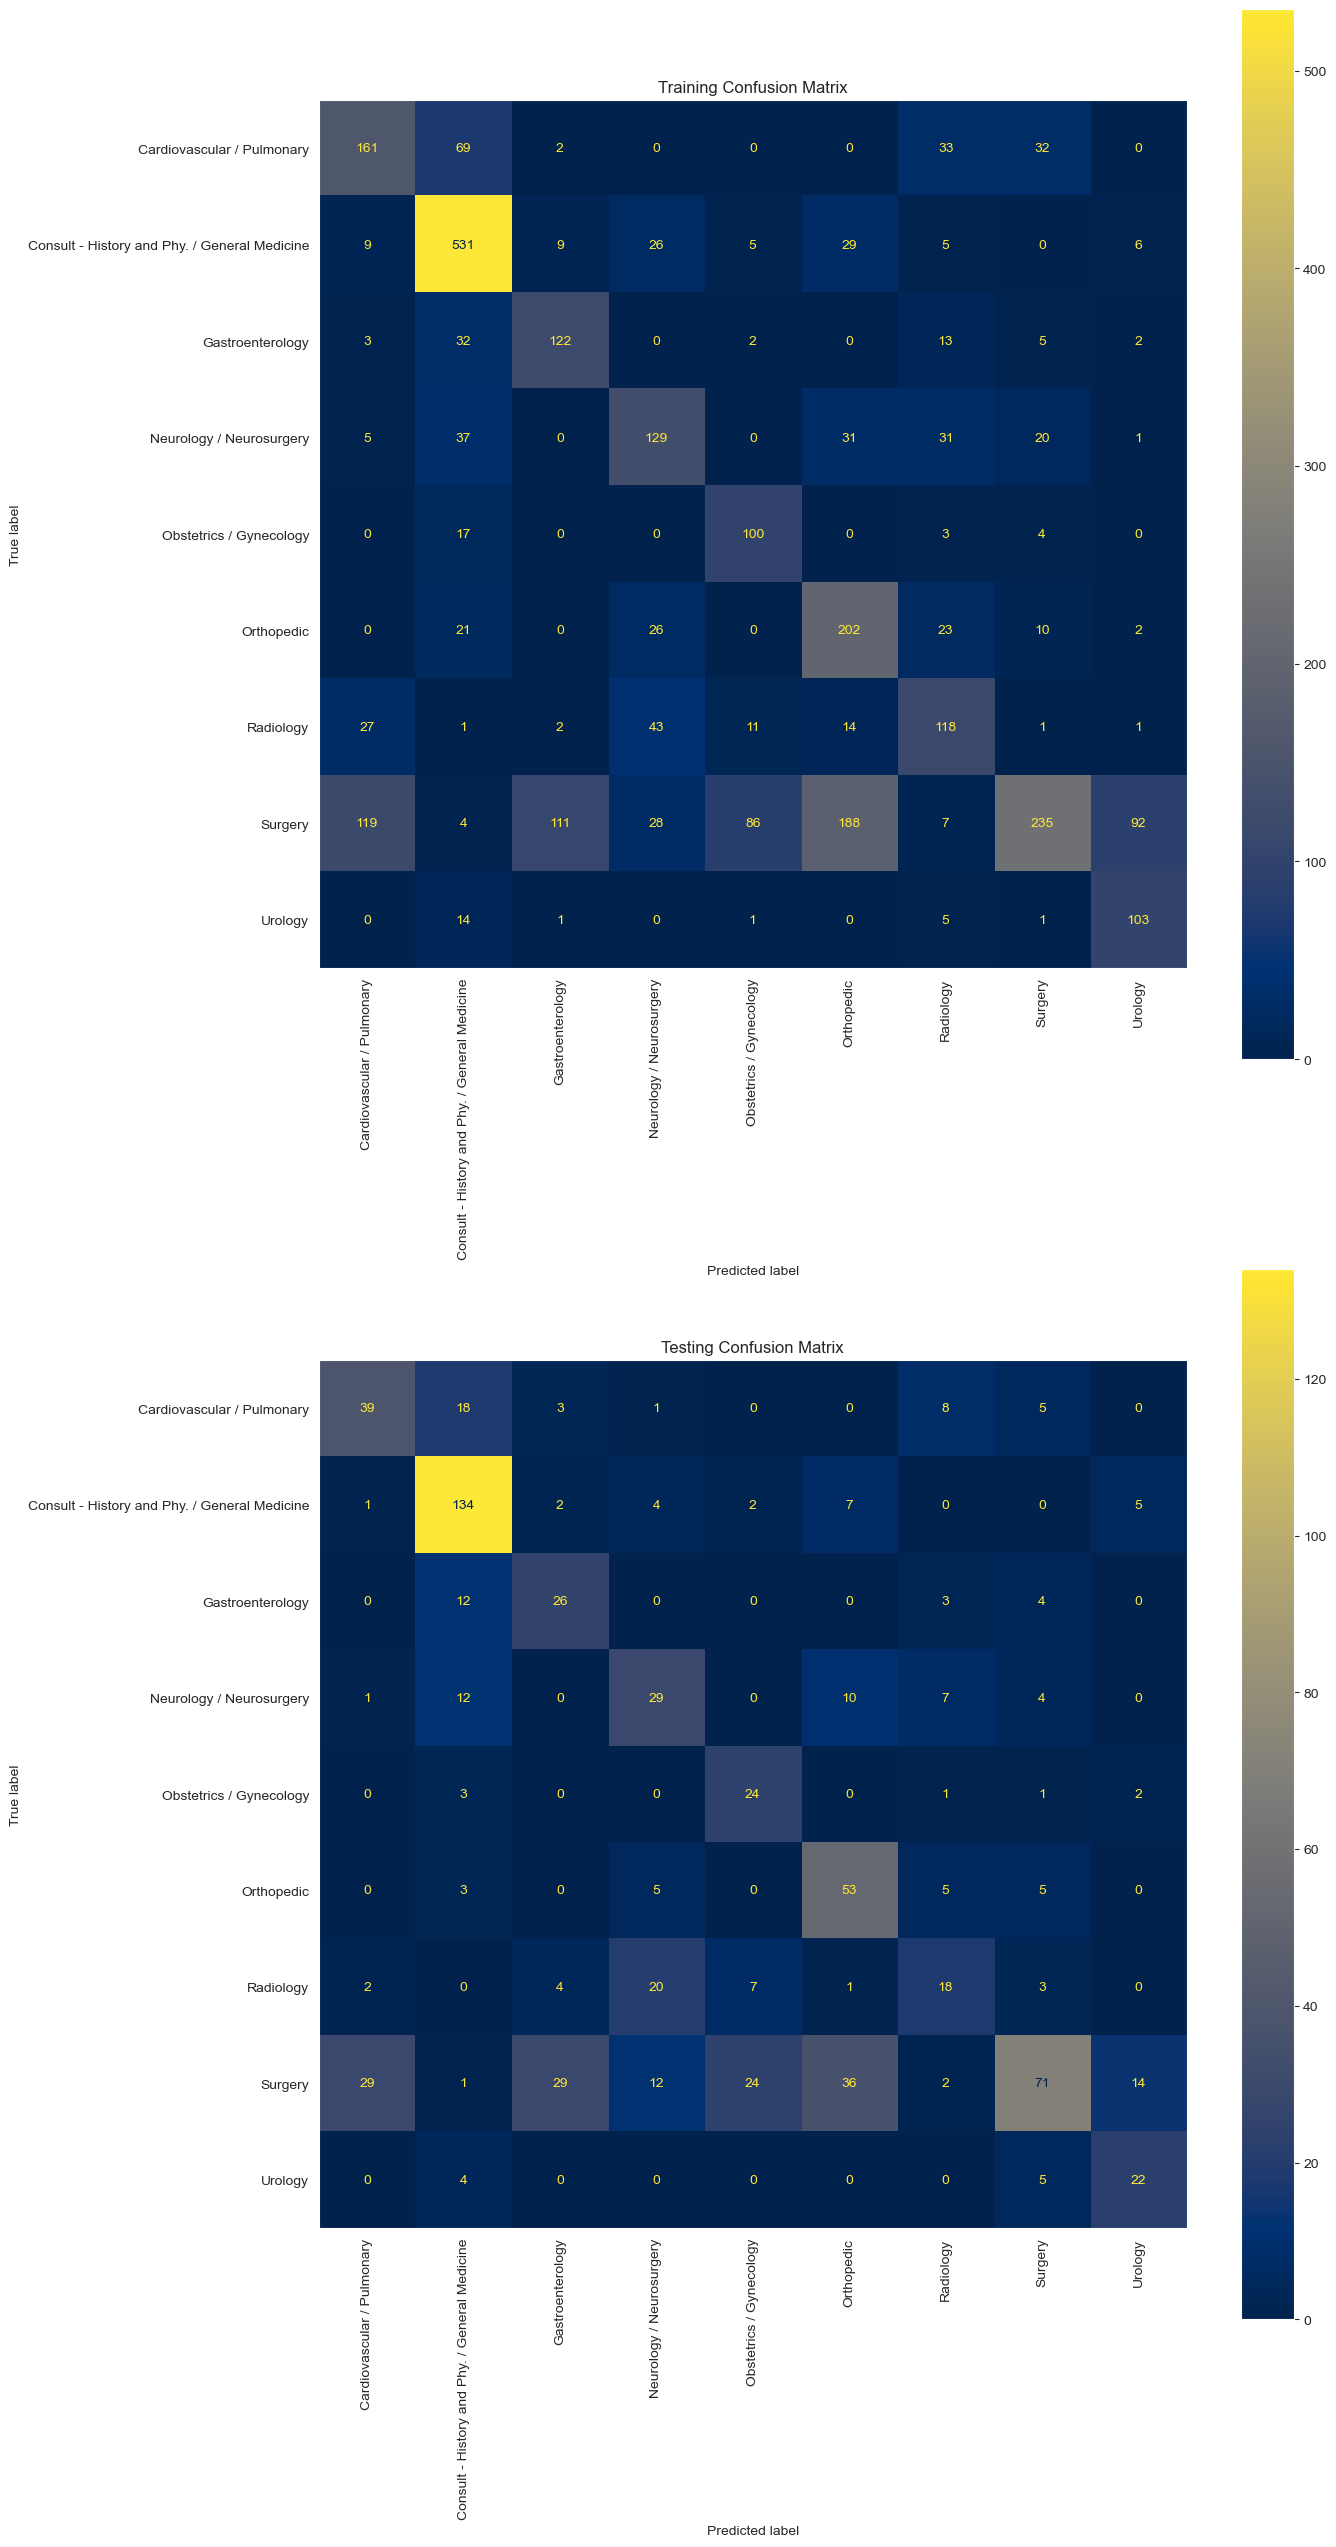

In [102]:
best_log = evaluate_grid(log_grid)

# MultinomialNB

In [91]:
mb_pipe = Pipeline([('feat_union',feat_union),('model',MultinomialNB())])

mb_params = {
    'feat_union__vec':vectorizers, #testing vectorizers
    'feat_union__vec__min_df':[0.025], #tried 0.025,0.05
    'feat_union__vec__max_df':[0.75], #tried 0.75,0.9,0.95
    'feat_union__topics__vec':vectorizers,
    'feat_union__topics__vec__min_df':[5,0.025], #tried 5, 0.025, 0.05
    'feat_union__topics__vec__max_df':[0.75, 0.95], # tried 0.75, 0.9, 0.95
    'feat_union__topics__nmf__l1_ratio':[0,0.2,0.3], #tried 0,0.1,0.2,0.3
    #'feat_union__topics__nmf__alpha_W':[0,0.1], leads to many warnings, i guess it ends up making topic weights null with any l1 reg.
    'feat_union__topics__nmf__max_iter':[1000], #no more convergence warnings
    'model__alpha': [0.05, 0.1] # tried 0.05, 0.1,0.5,1,2
}

mb_grid = GridSearchCV(mb_pipe,mb_params,cv=5,scoring=scoring,refit='weighted_f1')

{'feat_union__topics__nmf__l1_ratio': 0, 'feat_union__topics__nmf__max_iter': 1000, 'feat_union__topics__vec': TfidfVectorizer(max_df=0.75, min_df=5), 'feat_union__topics__vec__max_df': 0.75, 'feat_union__topics__vec__min_df': 5, 'feat_union__vec': CountVectorizer(max_df=0.75, min_df=0.025), 'feat_union__vec__max_df': 0.75, 'feat_union__vec__min_df': 0.025, 'model__alpha': 0.1}
-----------------
Training Accuracy:  0.583641871423763
Training Precision:  0.5889074218935201
Training Recall:  0.583641871423763
Training F1:  0.5687210833778998
-----------------
Cross-Validation Accuracy:  0.5193594205358911
Cross-Validation Precision:  0.5092907537079467
Cross-Validation Recall:  0.5193594205358911
Cross-Validation F1:  0.5024938211952336
-----------------
Testing Accuracy:  0.5262449528936743
Testing Precision:  0.5219065906686536
Testing Recall:  0.5262449528936743
Testing F1:  0.5132727511309548


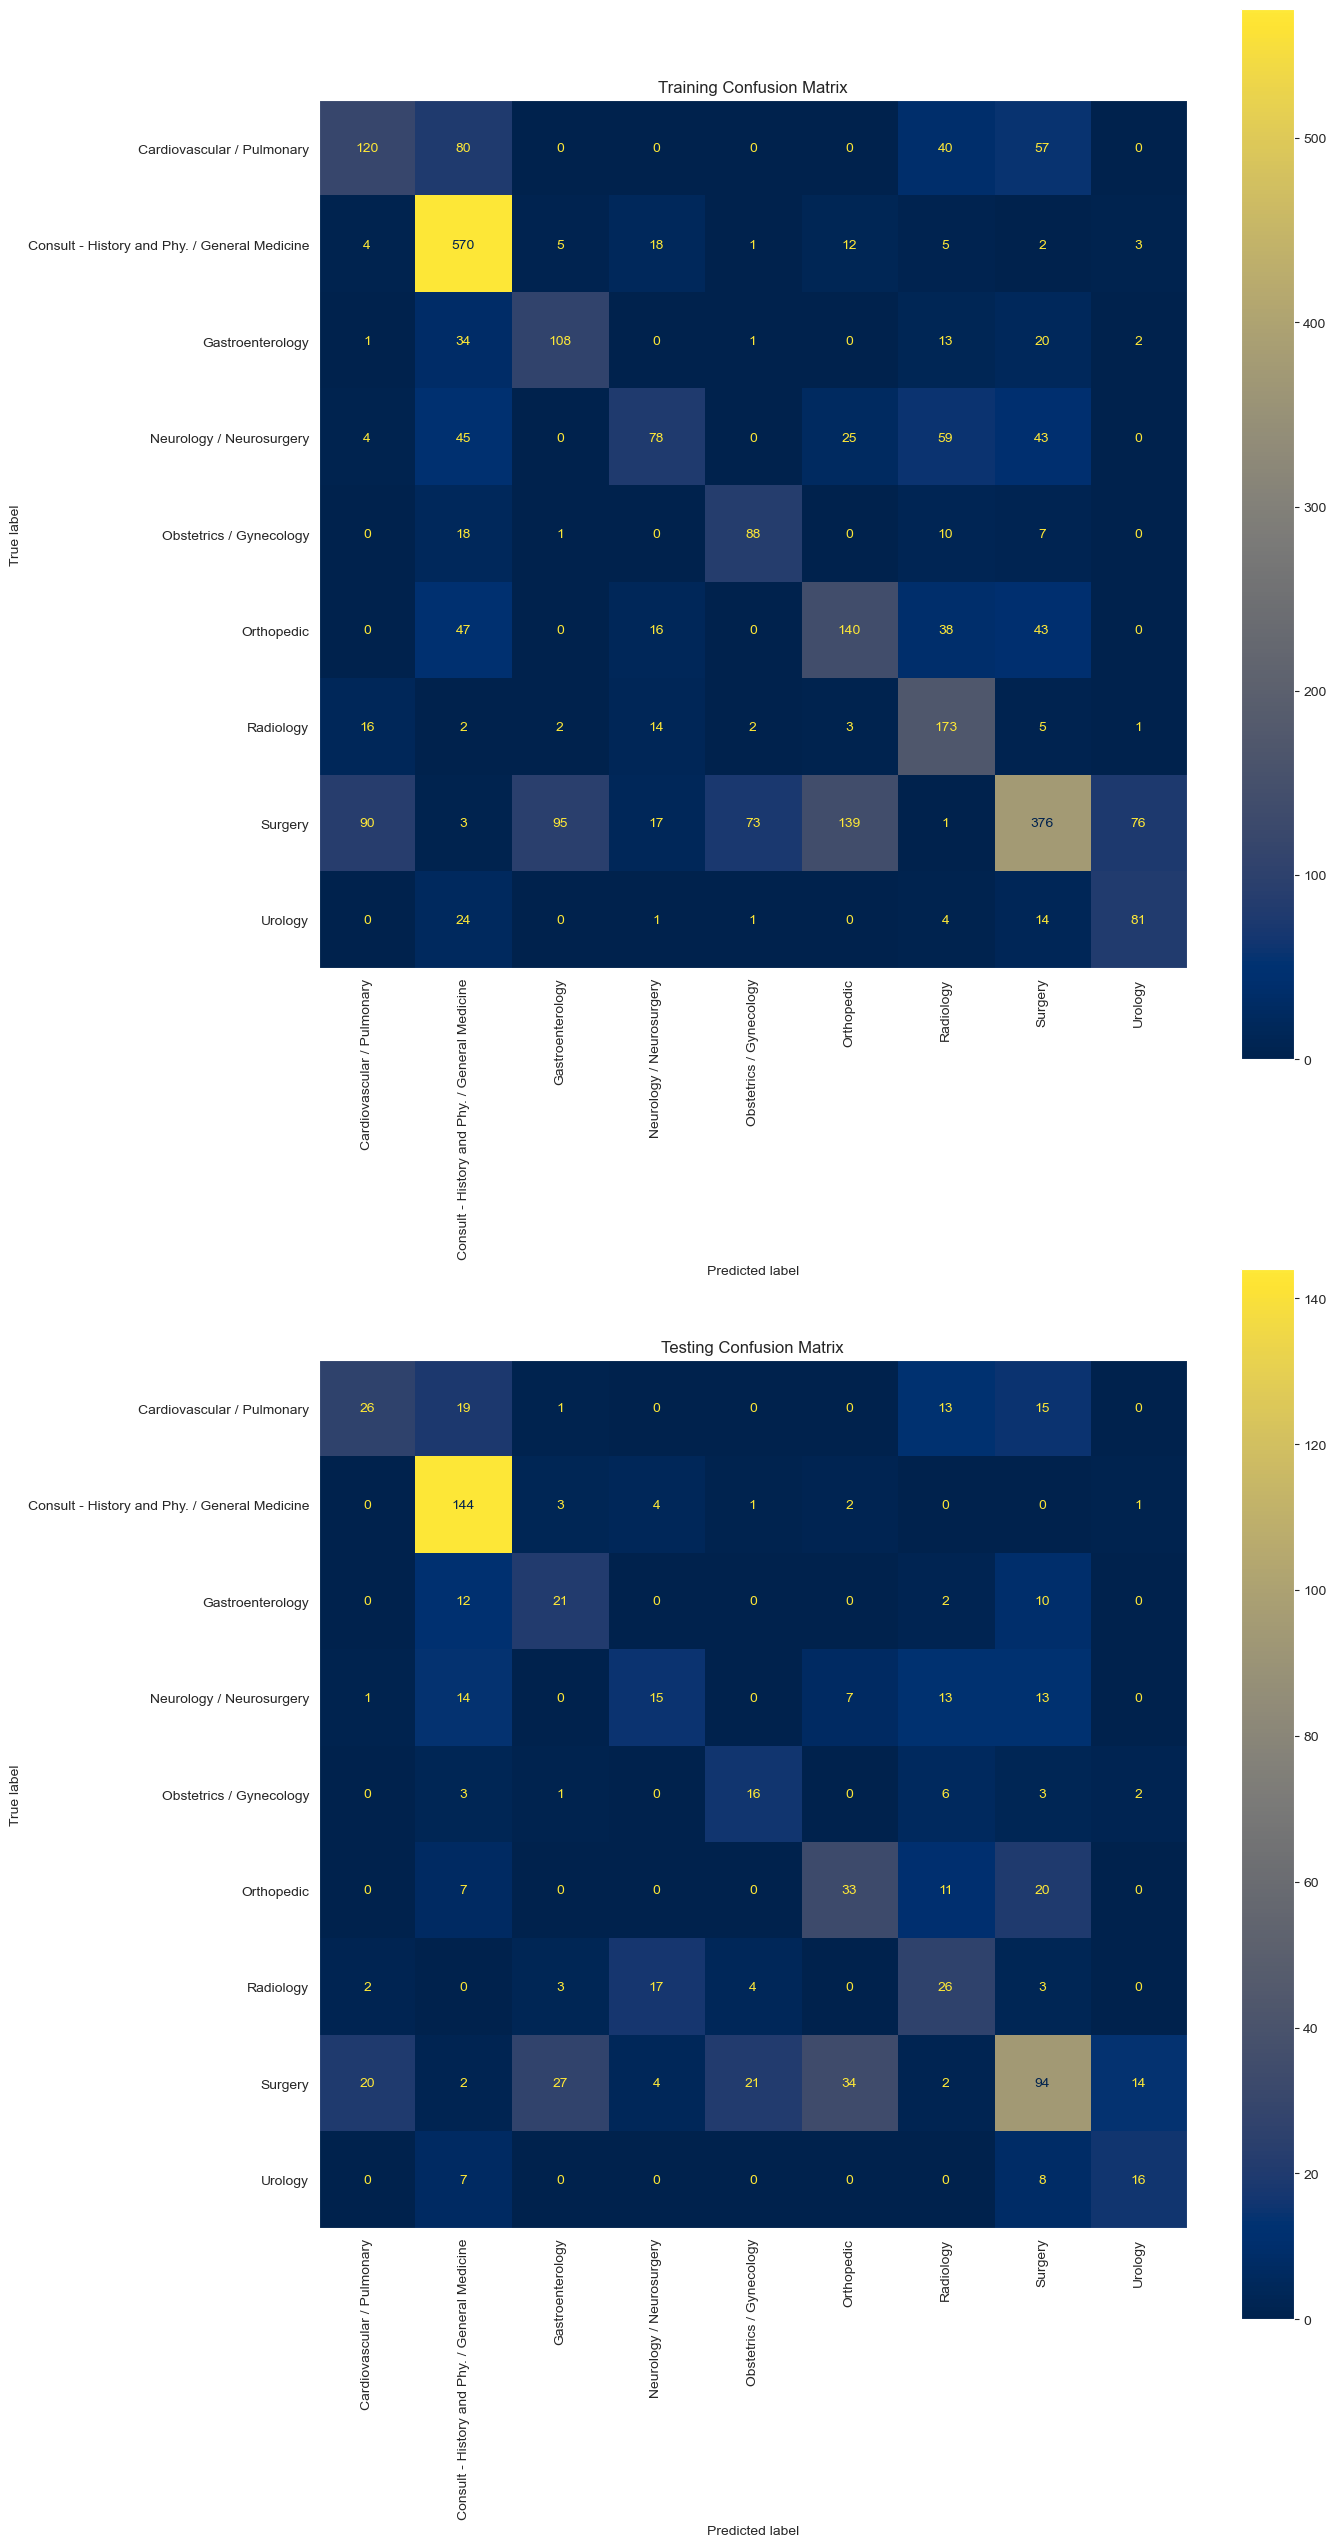

In [92]:
best_mb = evaluate_grid(mb_grid)

# ComplementNB

In [93]:
cb_pipe = Pipeline([('feat_union',feat_union),('model',ComplementNB())])

cb_params = {
    'feat_union__vec':vectorizers,
    'feat_union__vec__min_df':[0.025],
    'feat_union__vec__max_df':[0.75],
    'feat_union__topics__vec':vectorizers,
    'feat_union__topics__vec__min_df':[5,0.025], 
    'feat_union__topics__vec__max_df':[0.75, 0.95], 
    'feat_union__topics__nmf__l1_ratio':[0], 
    'feat_union__topics__nmf__max_iter':[1000],
    'model__alpha': [0.1,0.5]
}

cb_grid = GridSearchCV(cb_pipe,cb_params,cv=5,scoring=scoring,refit='weighted_f1')

{'feat_union__topics__nmf__l1_ratio': 0, 'feat_union__topics__nmf__max_iter': 1000, 'feat_union__topics__vec': TfidfVectorizer(max_df=0.75, min_df=0.025), 'feat_union__topics__vec__max_df': 0.75, 'feat_union__topics__vec__min_df': 5, 'feat_union__vec': TfidfVectorizer(max_df=0.75, min_df=0.025), 'feat_union__vec__max_df': 0.75, 'feat_union__vec__min_df': 0.025, 'model__alpha': 0.5}
-----------------
Training Accuracy:  0.5617637159205655
Training Precision:  0.5452453149901274
Training Recall:  0.5617637159205655
Training F1:  0.49389604230265616
-----------------
Cross-Validation Accuracy:  0.5351758481170246
Cross-Validation Precision:  0.4870815540365405
Cross-Validation Recall:  0.5351758481170246
Cross-Validation F1:  0.4581882912858172
-----------------
Testing Accuracy:  0.550471063257066
Testing Precision:  0.534748163021404
Testing Recall:  0.550471063257066
Testing F1:  0.4761663549345243


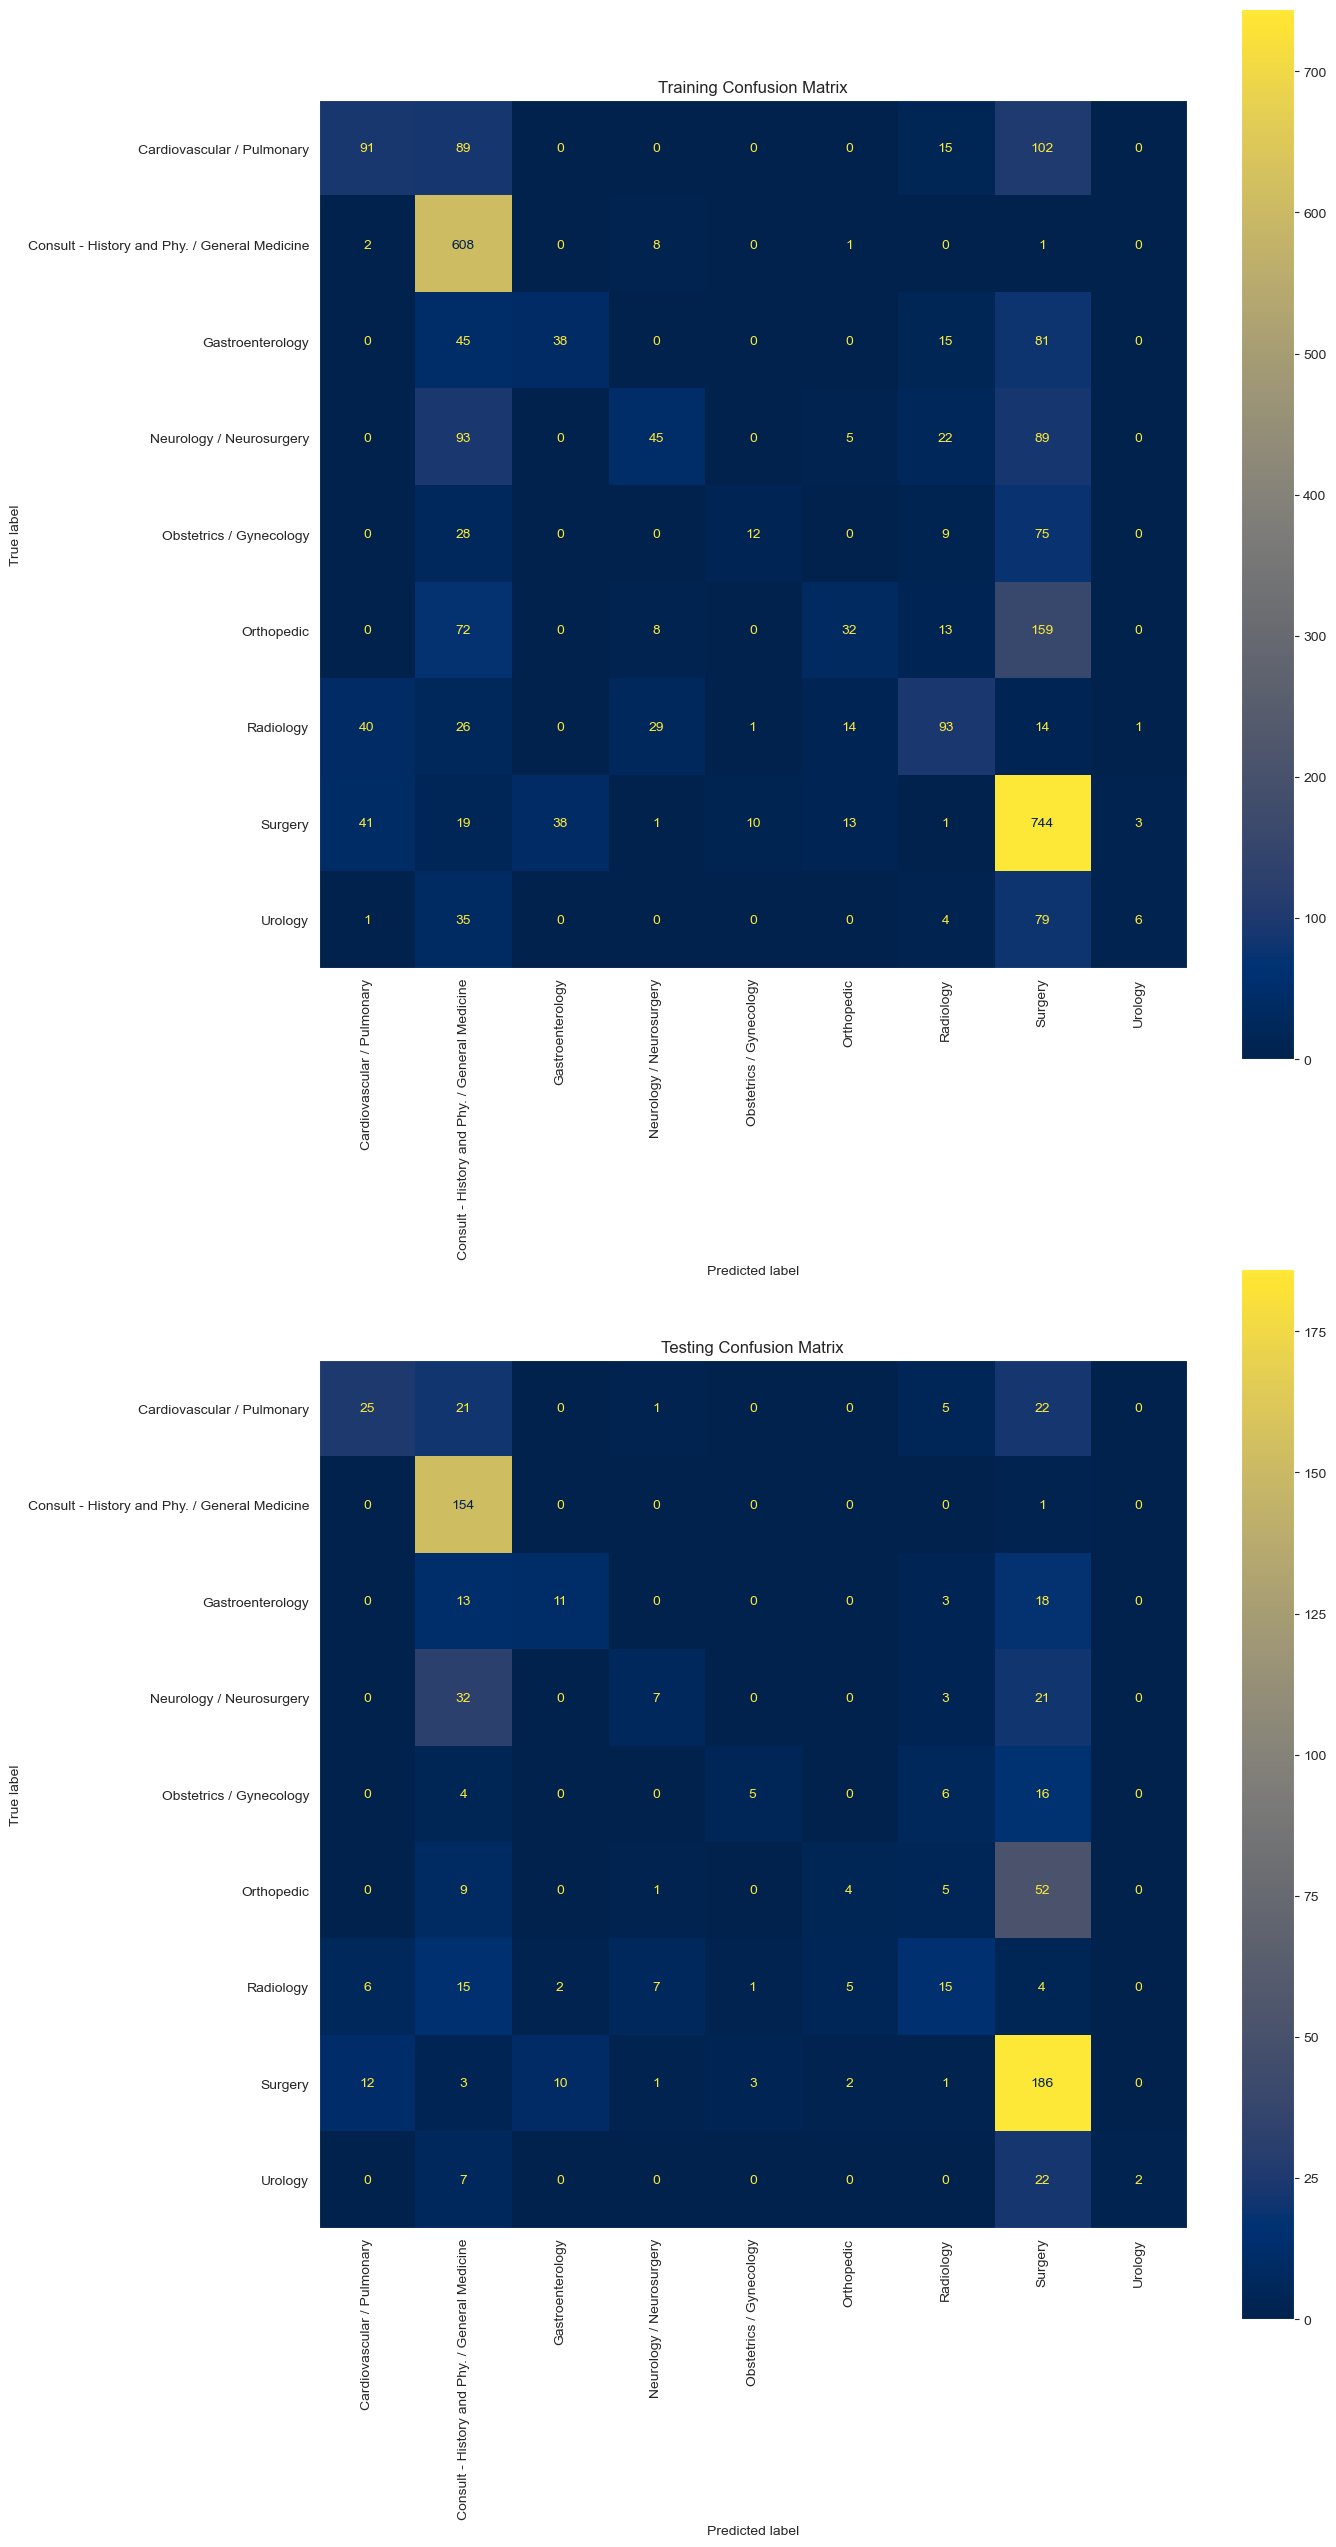

In [94]:
best_cb = evaluate_grid(cb_grid)

# Random Forest

In [95]:
rft_pipe = Pipeline([('feat_union',feat_union),('model',RandomForestClassifier(random_state=42))])

#min_samples_leaf
#max_features
#criterion
#max_depth

rft_params = {
    'feat_union__vec':vectorizers,
    'feat_union__vec__min_df':[0.025],
    'feat_union__vec__max_df':[0.75],
    'feat_union__topics__vec__min_df':[5],
    'feat_union__topics__vec__max_df':[0.75],
    'feat_union__topics__nmf__l1_ratio':[0],
    'feat_union__topics__nmf__max_iter':[1000],
    'model__n_estimators': [200,500],
    'model__max_depth':[3,4],
    'model__criterion':['entropy'], #entropy did better than gini
    'model__class_weight': ['balanced'] #helped a lot but scores still bad
}

rft_grid = GridSearchCV(rft_pipe,rft_params,cv=5,scoring=scoring,refit='weighted_f1')

{'feat_union__topics__nmf__l1_ratio': 0, 'feat_union__topics__nmf__max_iter': 1000, 'feat_union__topics__vec__max_df': 0.75, 'feat_union__topics__vec__min_df': 5, 'feat_union__vec': CountVectorizer(max_df=0.75, min_df=0.025), 'feat_union__vec__max_df': 0.75, 'feat_union__vec__min_df': 0.025, 'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__max_depth': 3, 'model__n_estimators': 500}
-----------------
Training Accuracy:  0.5466173005721979
Training Precision:  0.5743191341779937
Training Recall:  0.5466173005721979
Training F1:  0.5289709393851558
-----------------
Cross-Validation Accuracy:  0.5085872732931557
Cross-Validation Precision:  0.5338808636093586
Cross-Validation Recall:  0.5085872732931557
Cross-Validation F1:  0.48939930309978524
-----------------
Testing Accuracy:  0.5329744279946165
Testing Precision:  0.55675449837415
Testing Recall:  0.5329744279946165
Testing F1:  0.5114069708338478


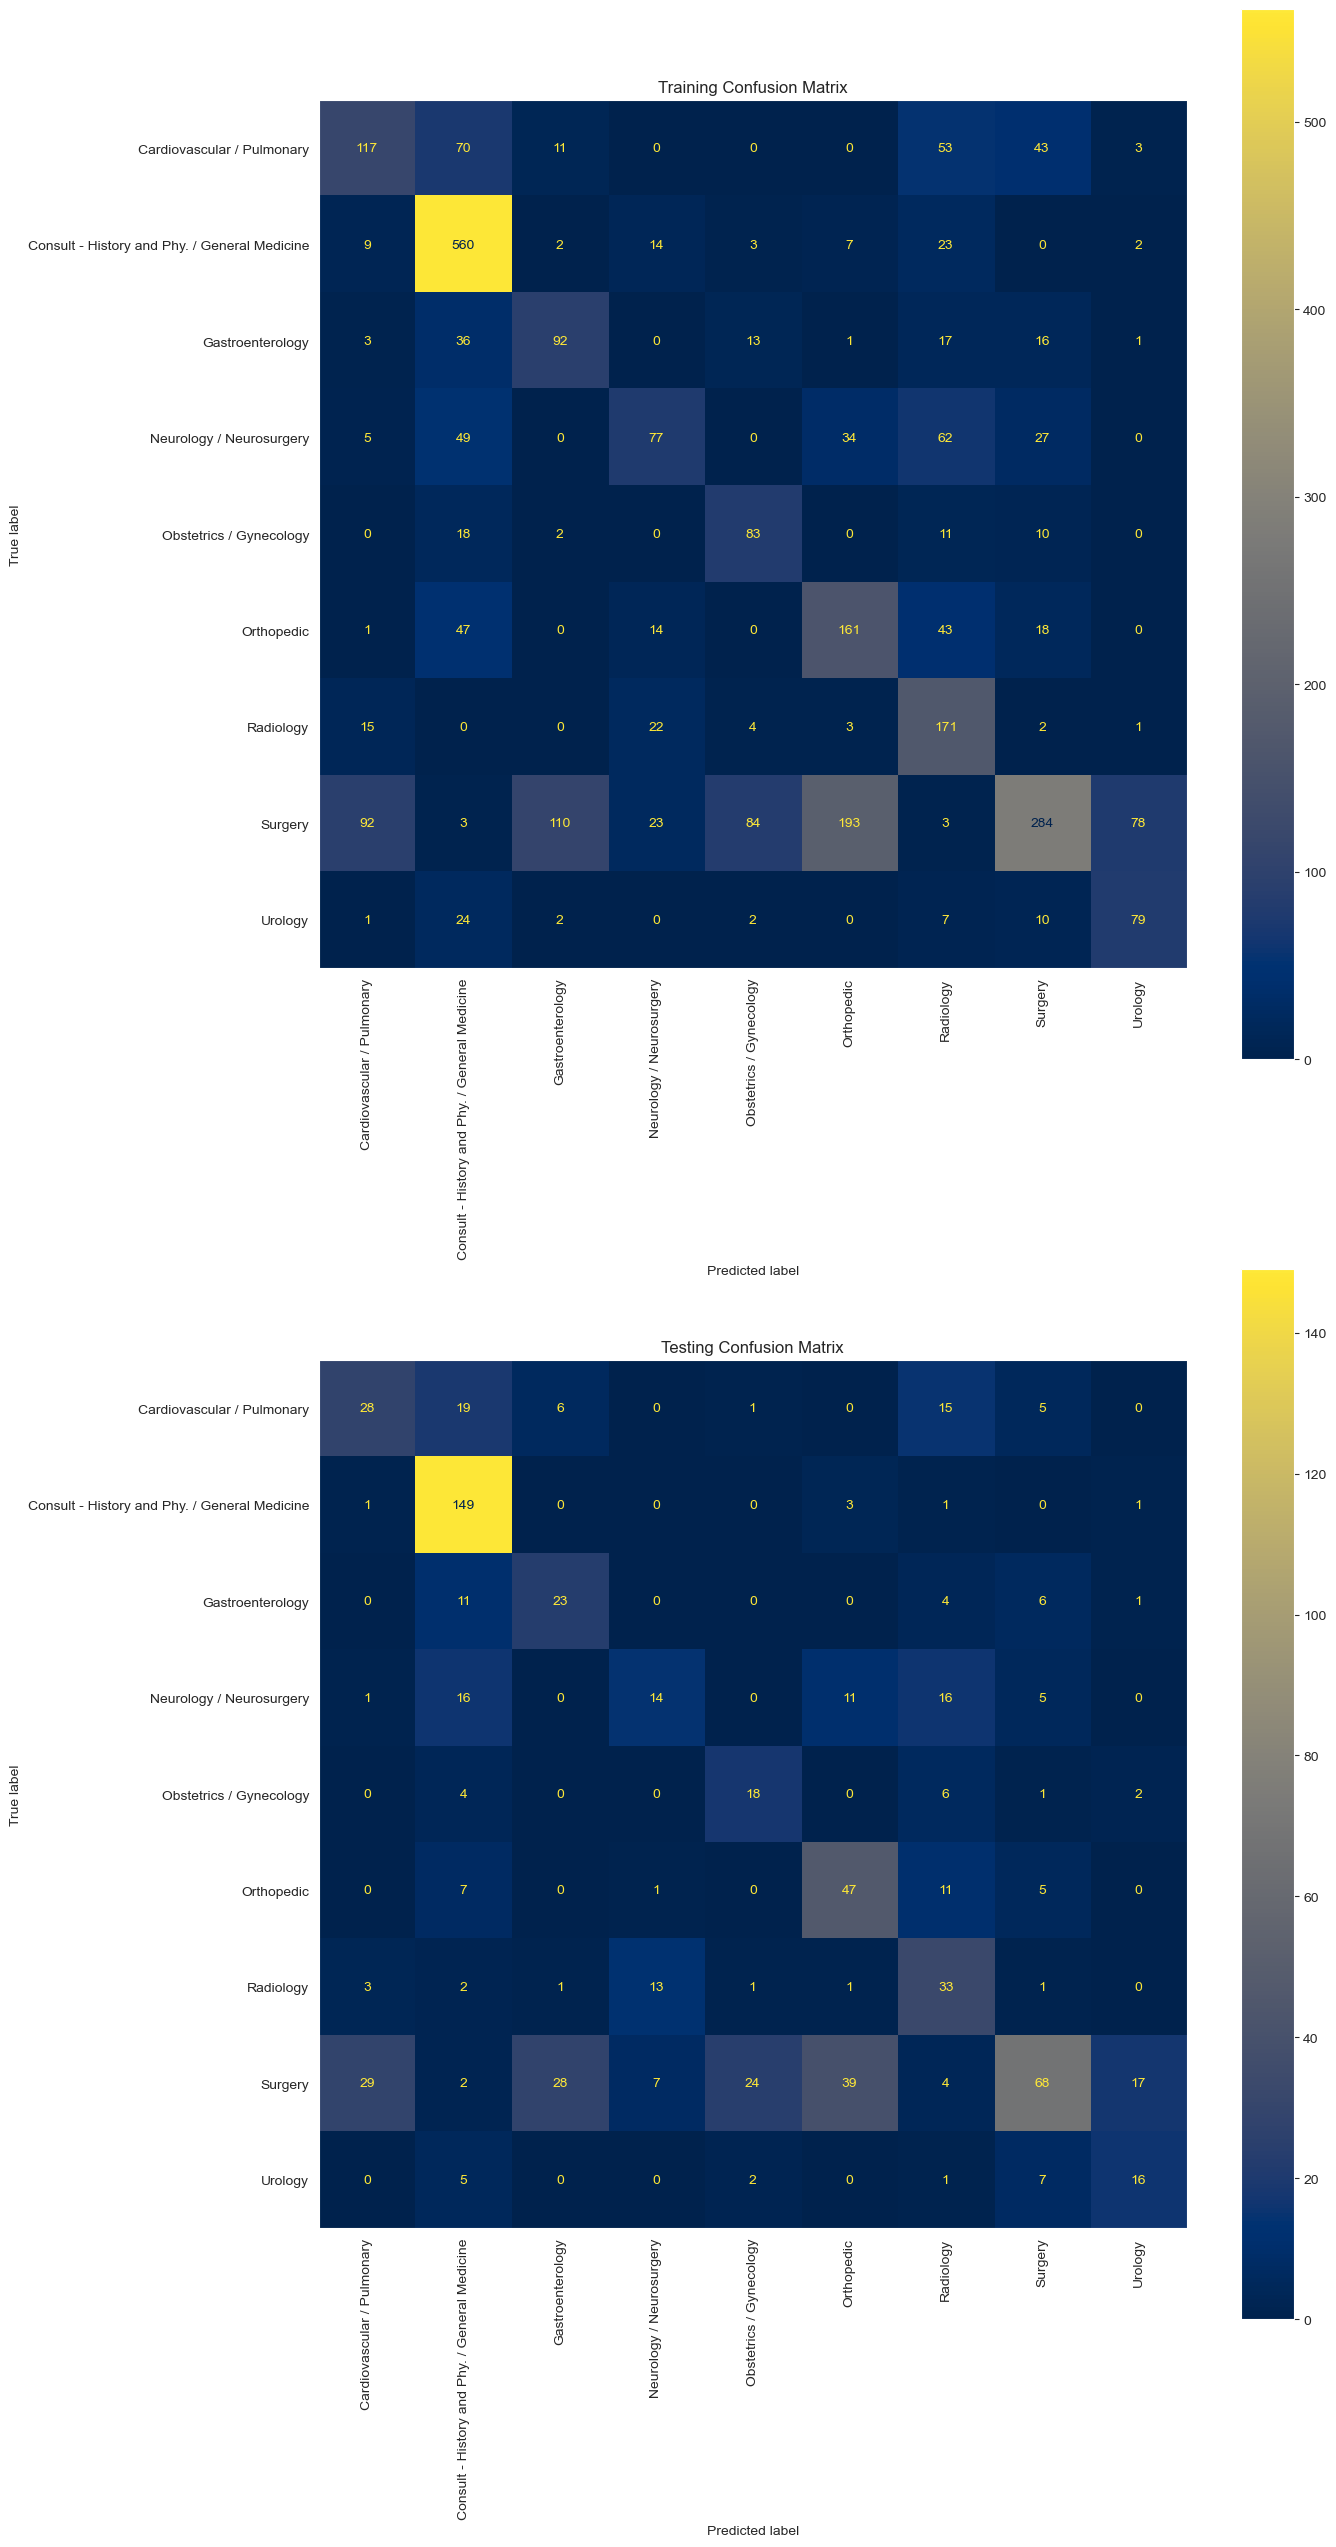

In [96]:
best_rft = evaluate_grid(rft_grid)

# Catboost

In [97]:
cat_pipe = Pipeline([('feat_union',feat_union),('model',CatBoostClassifier(random_state=42))])

cat_params = {
    'feat_union__vec__min_df':[0.025],
    'feat_union__vec__max_df':[0.75],
    'feat_union__topics__vec__min_df':[5],
    'feat_union__topics__vec__max_df':[0.75],
    'feat_union__topics__nmf__max_iter':[1000],
    'model__n_estimators': [100,200],
    'model__max_depth':[3,5],
    'model__learning_rate':[0.2,0.3],
    'model__colsample_bylevel': [0.75],
    'model__early_stopping_rounds':[10],
    'model__auto_class_weights': ['Balanced'],
    'model__l2_leaf_reg':[10],
    'model__boosting_type': ['Ordered']
}

cat_grid = GridSearchCV(cat_pipe,cat_params,cv=5,scoring=scoring,refit='weighted_f1')

0:	learn: 2.1461144	total: 571ms	remaining: 56.5s
1:	learn: 2.0877759	total: 882ms	remaining: 43.2s
2:	learn: 2.0476988	total: 1.11s	remaining: 36s
3:	learn: 2.0099438	total: 1.45s	remaining: 34.8s
4:	learn: 1.9416639	total: 1.68s	remaining: 31.9s
5:	learn: 1.9116016	total: 1.98s	remaining: 31.1s
6:	learn: 1.8430204	total: 2.2s	remaining: 29.3s
7:	learn: 1.8064508	total: 2.48s	remaining: 28.5s
8:	learn: 1.7414105	total: 2.69s	remaining: 27.2s
9:	learn: 1.6989494	total: 2.98s	remaining: 26.8s
10:	learn: 1.6788174	total: 3.18s	remaining: 25.7s
11:	learn: 1.6608256	total: 3.48s	remaining: 25.6s
12:	learn: 1.6513895	total: 3.7s	remaining: 24.7s
13:	learn: 1.6422028	total: 3.97s	remaining: 24.4s
14:	learn: 1.6257573	total: 4.17s	remaining: 23.6s
15:	learn: 1.5787759	total: 4.46s	remaining: 23.4s
16:	learn: 1.5521191	total: 4.71s	remaining: 23s
17:	learn: 1.5294370	total: 5.05s	remaining: 23s
18:	learn: 1.5028711	total: 5.27s	remaining: 22.5s
19:	learn: 1.4975267	total: 5.54s	remaining: 22.2

63:	learn: 1.1312426	total: 15.9s	remaining: 8.92s
64:	learn: 1.1247044	total: 16.1s	remaining: 8.66s
65:	learn: 1.1210736	total: 16.4s	remaining: 8.43s
66:	learn: 1.1183863	total: 16.6s	remaining: 8.16s
67:	learn: 1.1124775	total: 16.9s	remaining: 7.93s
68:	learn: 1.1109045	total: 17.1s	remaining: 7.67s
69:	learn: 1.1061298	total: 17.3s	remaining: 7.43s
70:	learn: 1.1012372	total: 17.6s	remaining: 7.18s
71:	learn: 1.0969768	total: 17.8s	remaining: 6.93s
72:	learn: 1.0935193	total: 18s	remaining: 6.67s
73:	learn: 1.0916514	total: 18.3s	remaining: 6.43s
74:	learn: 1.0876242	total: 18.5s	remaining: 6.16s
75:	learn: 1.0852301	total: 18.8s	remaining: 5.93s
76:	learn: 1.0833624	total: 19s	remaining: 5.67s
77:	learn: 1.0811747	total: 19.3s	remaining: 5.43s
78:	learn: 1.0769474	total: 19.5s	remaining: 5.17s
79:	learn: 1.0737938	total: 19.7s	remaining: 4.93s
80:	learn: 1.0722528	total: 20s	remaining: 4.68s
81:	learn: 1.0673109	total: 20.2s	remaining: 4.44s
82:	learn: 1.0661225	total: 20.4s	rem

26:	learn: 1.4114614	total: 6.73s	remaining: 18.2s
27:	learn: 1.3945533	total: 7s	remaining: 18s
28:	learn: 1.3887977	total: 7.2s	remaining: 17.6s
29:	learn: 1.3829387	total: 7.45s	remaining: 17.4s
30:	learn: 1.3709372	total: 7.64s	remaining: 17s
31:	learn: 1.3672944	total: 7.93s	remaining: 16.9s
32:	learn: 1.3635091	total: 8.16s	remaining: 16.6s
33:	learn: 1.3507839	total: 8.44s	remaining: 16.4s
34:	learn: 1.3457930	total: 8.66s	remaining: 16.1s
35:	learn: 1.3316170	total: 8.94s	remaining: 15.9s
36:	learn: 1.3187316	total: 9.14s	remaining: 15.6s
37:	learn: 1.3064165	total: 9.45s	remaining: 15.4s
38:	learn: 1.2967897	total: 9.7s	remaining: 15.2s
39:	learn: 1.2780651	total: 9.99s	remaining: 15s
40:	learn: 1.2678816	total: 10.2s	remaining: 14.7s
41:	learn: 1.2568659	total: 10.5s	remaining: 14.5s
42:	learn: 1.2487549	total: 10.7s	remaining: 14.2s
43:	learn: 1.2444017	total: 11s	remaining: 13.9s
44:	learn: 1.2332813	total: 11.1s	remaining: 13.6s
45:	learn: 1.2207382	total: 11.4s	remaining:

88:	learn: 1.0549944	total: 21.9s	remaining: 2.71s
89:	learn: 1.0485929	total: 22.2s	remaining: 2.46s
90:	learn: 1.0458329	total: 22.4s	remaining: 2.21s
91:	learn: 1.0449787	total: 22.6s	remaining: 1.97s
92:	learn: 1.0380087	total: 22.8s	remaining: 1.72s
93:	learn: 1.0360480	total: 23.1s	remaining: 1.48s
94:	learn: 1.0313057	total: 23.3s	remaining: 1.23s
95:	learn: 1.0309659	total: 23.6s	remaining: 984ms
96:	learn: 1.0306412	total: 23.8s	remaining: 736ms
97:	learn: 1.0291296	total: 24.1s	remaining: 491ms
98:	learn: 1.0284262	total: 24.3s	remaining: 245ms
99:	learn: 1.0255965	total: 24.5s	remaining: 0us
0:	learn: 2.1461144	total: 202ms	remaining: 40.2s
1:	learn: 2.0877759	total: 506ms	remaining: 50.1s
2:	learn: 2.0476988	total: 705ms	remaining: 46.3s
3:	learn: 2.0099438	total: 949ms	remaining: 46.5s
4:	learn: 1.9416639	total: 1.14s	remaining: 44.4s
5:	learn: 1.9116016	total: 1.43s	remaining: 46.1s
6:	learn: 1.8430204	total: 1.64s	remaining: 45.1s
7:	learn: 1.8064508	total: 1.92s	remaini

149:	learn: 0.9437748	total: 36s	remaining: 12s
150:	learn: 0.9395649	total: 36.2s	remaining: 11.8s
151:	learn: 0.9386538	total: 36.5s	remaining: 11.5s
152:	learn: 0.9373792	total: 36.7s	remaining: 11.3s
153:	learn: 0.9321339	total: 37s	remaining: 11s
154:	learn: 0.9316624	total: 37.2s	remaining: 10.8s
155:	learn: 0.9312741	total: 37.5s	remaining: 10.6s
156:	learn: 0.9302212	total: 37.7s	remaining: 10.3s
157:	learn: 0.9297569	total: 37.9s	remaining: 10.1s
158:	learn: 0.9288553	total: 38.1s	remaining: 9.83s
159:	learn: 0.9276491	total: 38.4s	remaining: 9.6s
160:	learn: 0.9273961	total: 38.6s	remaining: 9.35s
161:	learn: 0.9262196	total: 38.9s	remaining: 9.12s
162:	learn: 0.9259241	total: 39.1s	remaining: 8.88s
163:	learn: 0.9257715	total: 39.4s	remaining: 8.65s
164:	learn: 0.9248888	total: 39.6s	remaining: 8.4s
165:	learn: 0.9244078	total: 39.8s	remaining: 8.16s
166:	learn: 0.9239000	total: 40.1s	remaining: 7.92s
167:	learn: 0.9234272	total: 40.3s	remaining: 7.68s
168:	learn: 0.9225660	

111:	learn: 1.0181278	total: 26.2s	remaining: 20.6s
112:	learn: 1.0178661	total: 26.4s	remaining: 20.3s
113:	learn: 1.0171709	total: 26.7s	remaining: 20.1s
114:	learn: 1.0157787	total: 26.9s	remaining: 19.9s
115:	learn: 1.0137836	total: 27.1s	remaining: 19.6s
116:	learn: 1.0122886	total: 27.3s	remaining: 19.4s
117:	learn: 1.0103447	total: 27.6s	remaining: 19.2s
118:	learn: 1.0085901	total: 27.8s	remaining: 18.9s
119:	learn: 1.0081711	total: 28.1s	remaining: 18.7s
120:	learn: 1.0070094	total: 28.3s	remaining: 18.5s
121:	learn: 1.0065418	total: 28.6s	remaining: 18.3s
122:	learn: 1.0054339	total: 28.8s	remaining: 18s
123:	learn: 1.0050415	total: 29.1s	remaining: 17.8s
124:	learn: 1.0037312	total: 29.3s	remaining: 17.6s
125:	learn: 1.0034236	total: 29.6s	remaining: 17.4s
126:	learn: 1.0015447	total: 29.8s	remaining: 17.1s
127:	learn: 1.0006885	total: 30s	remaining: 16.9s
128:	learn: 1.0004039	total: 30.3s	remaining: 16.7s
129:	learn: 0.9994155	total: 30.5s	remaining: 16.4s
130:	learn: 0.99

72:	learn: 1.0817302	total: 17.3s	remaining: 30.2s
73:	learn: 1.0792224	total: 17.6s	remaining: 30s
74:	learn: 1.0777990	total: 17.8s	remaining: 29.7s
75:	learn: 1.0743234	total: 18.1s	remaining: 29.5s
76:	learn: 1.0726028	total: 18.3s	remaining: 29.2s
77:	learn: 1.0714629	total: 18.5s	remaining: 29s
78:	learn: 1.0674354	total: 18.7s	remaining: 28.7s
79:	learn: 1.0649866	total: 19s	remaining: 28.5s
80:	learn: 1.0625813	total: 19.2s	remaining: 28.2s
81:	learn: 1.0583999	total: 19.5s	remaining: 28s
82:	learn: 1.0566472	total: 19.7s	remaining: 27.7s
83:	learn: 1.0560505	total: 19.9s	remaining: 27.5s
84:	learn: 1.0544335	total: 20.1s	remaining: 27.2s
85:	learn: 1.0508320	total: 20.4s	remaining: 27s
86:	learn: 1.0475024	total: 20.6s	remaining: 26.8s
87:	learn: 1.0448708	total: 20.9s	remaining: 26.6s
88:	learn: 1.0444767	total: 21.1s	remaining: 26.3s
89:	learn: 1.0411770	total: 21.4s	remaining: 26.1s
90:	learn: 1.0386705	total: 21.6s	remaining: 25.9s
91:	learn: 1.0380479	total: 21.9s	remaini

32:	learn: 1.3635091	total: 8.06s	remaining: 40.8s
33:	learn: 1.3507839	total: 8.32s	remaining: 40.6s
34:	learn: 1.3457930	total: 8.5s	remaining: 40.1s
35:	learn: 1.3316170	total: 8.76s	remaining: 39.9s
36:	learn: 1.3187316	total: 8.95s	remaining: 39.4s
37:	learn: 1.3064165	total: 9.21s	remaining: 39.2s
38:	learn: 1.2967897	total: 9.4s	remaining: 38.8s
39:	learn: 1.2780651	total: 9.69s	remaining: 38.8s
40:	learn: 1.2678816	total: 9.88s	remaining: 38.3s
41:	learn: 1.2568659	total: 10.1s	remaining: 38.2s
42:	learn: 1.2487549	total: 10.3s	remaining: 37.8s
43:	learn: 1.2444017	total: 10.6s	remaining: 37.6s
44:	learn: 1.2332813	total: 10.8s	remaining: 37.2s
45:	learn: 1.2207382	total: 11.1s	remaining: 37.1s
46:	learn: 1.2141458	total: 11.3s	remaining: 36.8s
47:	learn: 1.2078311	total: 11.6s	remaining: 36.6s
48:	learn: 1.1991954	total: 11.8s	remaining: 36.3s
49:	learn: 1.1865176	total: 12.1s	remaining: 36.2s
50:	learn: 1.1712710	total: 12.3s	remaining: 35.9s
51:	learn: 1.1646763	total: 12.6s

193:	learn: 0.9131569	total: 46.6s	remaining: 1.44s
194:	learn: 0.9129645	total: 46.8s	remaining: 1.2s
195:	learn: 0.9117841	total: 47.1s	remaining: 961ms
196:	learn: 0.9116722	total: 47.3s	remaining: 720ms
197:	learn: 0.9108547	total: 47.6s	remaining: 480ms
198:	learn: 0.9096929	total: 47.8s	remaining: 240ms
199:	learn: 0.9088955	total: 48s	remaining: 0us
0:	learn: 2.1031275	total: 236ms	remaining: 46.9s
1:	learn: 2.0553313	total: 531ms	remaining: 52.6s
2:	learn: 2.0215141	total: 724ms	remaining: 47.6s
3:	learn: 1.9585602	total: 996ms	remaining: 48.8s
4:	learn: 1.9291600	total: 1.2s	remaining: 46.7s
5:	learn: 1.8734524	total: 1.47s	remaining: 47.5s
6:	learn: 1.8373087	total: 1.69s	remaining: 46.7s
7:	learn: 1.7655103	total: 1.96s	remaining: 46.9s
8:	learn: 1.7390182	total: 2.16s	remaining: 45.8s
9:	learn: 1.7253632	total: 2.44s	remaining: 46.4s
10:	learn: 1.6974350	total: 2.66s	remaining: 45.8s
11:	learn: 1.6684893	total: 2.92s	remaining: 45.8s
12:	learn: 1.6492591	total: 3.13s	remain

155:	learn: 0.9476324	total: 38.2s	remaining: 10.8s
156:	learn: 0.9472442	total: 38.4s	remaining: 10.5s
157:	learn: 0.9465227	total: 38.7s	remaining: 10.3s
158:	learn: 0.9460277	total: 38.9s	remaining: 10s
159:	learn: 0.9449700	total: 39.1s	remaining: 9.78s
160:	learn: 0.9446496	total: 39.3s	remaining: 9.52s
161:	learn: 0.9431953	total: 39.6s	remaining: 9.28s
162:	learn: 0.9425914	total: 39.8s	remaining: 9.03s
163:	learn: 0.9411851	total: 40.1s	remaining: 8.8s
164:	learn: 0.9403308	total: 40.3s	remaining: 8.55s
165:	learn: 0.9394262	total: 40.6s	remaining: 8.31s
166:	learn: 0.9389064	total: 40.8s	remaining: 8.06s
167:	learn: 0.9373500	total: 41.1s	remaining: 7.82s
168:	learn: 0.9365079	total: 41.3s	remaining: 7.57s
169:	learn: 0.9344315	total: 41.6s	remaining: 7.33s
170:	learn: 0.9308765	total: 41.8s	remaining: 7.08s
171:	learn: 0.9301183	total: 42s	remaining: 6.84s
172:	learn: 0.9299998	total: 42.2s	remaining: 6.59s
173:	learn: 0.9284022	total: 42.5s	remaining: 6.35s
174:	learn: 0.928

17:	learn: 1.5305812	total: 5.77s	remaining: 26.3s
18:	learn: 1.4945671	total: 6.08s	remaining: 25.9s
19:	learn: 1.4785919	total: 6.4s	remaining: 25.6s
20:	learn: 1.4679278	total: 6.72s	remaining: 25.3s
21:	learn: 1.4505713	total: 7.04s	remaining: 25s
22:	learn: 1.4409493	total: 7.36s	remaining: 24.7s
23:	learn: 1.4192160	total: 7.68s	remaining: 24.3s
24:	learn: 1.4016757	total: 8s	remaining: 24s
25:	learn: 1.3847174	total: 8.31s	remaining: 23.7s
26:	learn: 1.3607985	total: 8.63s	remaining: 23.3s
27:	learn: 1.3563843	total: 8.95s	remaining: 23s
28:	learn: 1.3467527	total: 9.27s	remaining: 22.7s
29:	learn: 1.3380561	total: 9.59s	remaining: 22.4s
30:	learn: 1.3321367	total: 9.9s	remaining: 22s
31:	learn: 1.3175714	total: 10.2s	remaining: 21.7s
32:	learn: 1.3055187	total: 10.5s	remaining: 21.4s
33:	learn: 1.2921158	total: 10.9s	remaining: 21.1s
34:	learn: 1.2867594	total: 11.2s	remaining: 20.8s
35:	learn: 1.2796953	total: 11.5s	remaining: 20.5s
36:	learn: 1.2716858	total: 11.8s	remaining:

80:	learn: 0.9844842	total: 27.3s	remaining: 6.39s
81:	learn: 0.9834834	total: 27.6s	remaining: 6.06s
82:	learn: 0.9797212	total: 27.9s	remaining: 5.72s
83:	learn: 0.9780309	total: 28.3s	remaining: 5.39s
84:	learn: 0.9757251	total: 28.6s	remaining: 5.05s
85:	learn: 0.9727182	total: 29s	remaining: 4.72s
86:	learn: 0.9688444	total: 29.3s	remaining: 4.38s
87:	learn: 0.9670632	total: 29.6s	remaining: 4.04s
88:	learn: 0.9660556	total: 30s	remaining: 3.7s
89:	learn: 0.9648376	total: 30.3s	remaining: 3.36s
90:	learn: 0.9642732	total: 30.6s	remaining: 3.03s
91:	learn: 0.9625422	total: 30.9s	remaining: 2.69s
92:	learn: 0.9602287	total: 31.3s	remaining: 2.35s
93:	learn: 0.9593698	total: 31.6s	remaining: 2.02s
94:	learn: 0.9582609	total: 31.9s	remaining: 1.68s
95:	learn: 0.9576712	total: 32.2s	remaining: 1.34s
96:	learn: 0.9535620	total: 32.6s	remaining: 1.01s
97:	learn: 0.9521260	total: 32.9s	remaining: 671ms
98:	learn: 0.9505767	total: 33.2s	remaining: 336ms
99:	learn: 0.9445534	total: 33.5s	re

43:	learn: 1.1892971	total: 14.8s	remaining: 18.8s
44:	learn: 1.1831006	total: 15.1s	remaining: 18.5s
45:	learn: 1.1673603	total: 15.5s	remaining: 18.1s
46:	learn: 1.1497634	total: 15.8s	remaining: 17.8s
47:	learn: 1.1379765	total: 16.1s	remaining: 17.5s
48:	learn: 1.1328562	total: 16.4s	remaining: 17.1s
49:	learn: 1.1180845	total: 16.8s	remaining: 16.8s
50:	learn: 1.1078220	total: 17.1s	remaining: 16.4s
51:	learn: 1.1013425	total: 17.4s	remaining: 16.1s
52:	learn: 1.0888355	total: 17.8s	remaining: 15.7s
53:	learn: 1.0751520	total: 18.1s	remaining: 15.4s
54:	learn: 1.0663763	total: 18.4s	remaining: 15.1s
55:	learn: 1.0600024	total: 18.7s	remaining: 14.7s
56:	learn: 1.0548298	total: 19.1s	remaining: 14.4s
57:	learn: 1.0502630	total: 19.4s	remaining: 14.1s
58:	learn: 1.0440441	total: 19.7s	remaining: 13.7s
59:	learn: 1.0389670	total: 20.1s	remaining: 13.4s
60:	learn: 1.0351455	total: 20.4s	remaining: 13s
61:	learn: 1.0291101	total: 20.7s	remaining: 12.7s
62:	learn: 1.0243588	total: 21.1s

105:	learn: 0.9250414	total: 34.7s	remaining: 30.8s
106:	learn: 0.9236996	total: 35.1s	remaining: 30.5s
107:	learn: 0.9226754	total: 35.4s	remaining: 30.1s
108:	learn: 0.9221519	total: 35.7s	remaining: 29.8s
109:	learn: 0.9196736	total: 36.1s	remaining: 29.5s
110:	learn: 0.9165610	total: 36.4s	remaining: 29.2s
111:	learn: 0.9158624	total: 36.7s	remaining: 28.8s
112:	learn: 0.9153783	total: 37s	remaining: 28.5s
113:	learn: 0.9134742	total: 37.4s	remaining: 28.2s
114:	learn: 0.9120791	total: 37.7s	remaining: 27.9s
115:	learn: 0.9110768	total: 38s	remaining: 27.6s
116:	learn: 0.9096568	total: 38.4s	remaining: 27.2s
117:	learn: 0.9076029	total: 38.7s	remaining: 26.9s
118:	learn: 0.9071900	total: 39s	remaining: 26.6s
119:	learn: 0.9067239	total: 39.3s	remaining: 26.2s
120:	learn: 0.9056233	total: 39.7s	remaining: 25.9s
121:	learn: 0.9053876	total: 40s	remaining: 25.6s
122:	learn: 0.9049856	total: 40.3s	remaining: 25.2s
123:	learn: 0.9045343	total: 40.6s	remaining: 24.9s
124:	learn: 0.903795

66:	learn: 1.0418259	total: 22.5s	remaining: 44.7s
67:	learn: 1.0408458	total: 22.8s	remaining: 44.3s
68:	learn: 1.0385177	total: 23.2s	remaining: 44s
69:	learn: 1.0286588	total: 23.5s	remaining: 43.6s
70:	learn: 1.0248523	total: 23.9s	remaining: 43.4s
71:	learn: 1.0226776	total: 24.2s	remaining: 43s
72:	learn: 1.0203715	total: 24.5s	remaining: 42.6s
73:	learn: 1.0171310	total: 24.9s	remaining: 42.5s
74:	learn: 1.0138782	total: 25.3s	remaining: 42.2s
75:	learn: 1.0117078	total: 25.6s	remaining: 41.8s
76:	learn: 1.0100857	total: 26s	remaining: 41.5s
77:	learn: 1.0092499	total: 26.3s	remaining: 41.1s
78:	learn: 1.0063839	total: 26.6s	remaining: 40.8s
79:	learn: 1.0056639	total: 26.9s	remaining: 40.4s
80:	learn: 1.0041655	total: 27.3s	remaining: 40.1s
81:	learn: 0.9999689	total: 27.6s	remaining: 39.7s
82:	learn: 0.9975358	total: 27.9s	remaining: 39.4s
83:	learn: 0.9940769	total: 28.3s	remaining: 39s
84:	learn: 0.9935868	total: 28.6s	remaining: 38.7s
85:	learn: 0.9922149	total: 28.9s	remai

27:	learn: 1.3923876	total: 9.03s	remaining: 55.5s
28:	learn: 1.3762559	total: 9.35s	remaining: 55.1s
29:	learn: 1.3650062	total: 9.69s	remaining: 54.9s
30:	learn: 1.3533122	total: 10s	remaining: 54.6s
31:	learn: 1.3384286	total: 10.3s	remaining: 54.3s
32:	learn: 1.3261439	total: 10.7s	remaining: 54s
33:	learn: 1.3140326	total: 11s	remaining: 53.7s
34:	learn: 1.3089860	total: 11.3s	remaining: 53.4s
35:	learn: 1.3011489	total: 11.6s	remaining: 53.1s
36:	learn: 1.2897224	total: 12s	remaining: 52.7s
37:	learn: 1.2842645	total: 12.3s	remaining: 52.4s
38:	learn: 1.2653684	total: 12.6s	remaining: 52s
39:	learn: 1.2510063	total: 12.9s	remaining: 51.7s
40:	learn: 1.2421861	total: 13.2s	remaining: 51.3s
41:	learn: 1.2333701	total: 13.6s	remaining: 51s
42:	learn: 1.2201884	total: 13.9s	remaining: 50.6s
43:	learn: 1.2065876	total: 14.2s	remaining: 50.3s
44:	learn: 1.2022644	total: 14.5s	remaining: 50s
45:	learn: 1.1915017	total: 14.8s	remaining: 49.7s
46:	learn: 1.1833445	total: 15.2s	remaining: 

188:	learn: 0.8491060	total: 1m 1s	remaining: 3.59s
189:	learn: 0.8485780	total: 1m 1s	remaining: 3.26s
190:	learn: 0.8482259	total: 1m 2s	remaining: 2.93s
191:	learn: 0.8479073	total: 1m 2s	remaining: 2.61s
192:	learn: 0.8476823	total: 1m 2s	remaining: 2.28s
193:	learn: 0.8452534	total: 1m 3s	remaining: 1.96s
194:	learn: 0.8440036	total: 1m 3s	remaining: 1.63s
195:	learn: 0.8426367	total: 1m 3s	remaining: 1.3s
196:	learn: 0.8422039	total: 1m 4s	remaining: 978ms
197:	learn: 0.8418349	total: 1m 4s	remaining: 652ms
198:	learn: 0.8416370	total: 1m 4s	remaining: 326ms
199:	learn: 0.8413802	total: 1m 5s	remaining: 0us
0:	learn: 2.0959207	total: 319ms	remaining: 1m 3s
1:	learn: 2.0177064	total: 634ms	remaining: 1m 2s
2:	learn: 1.9607467	total: 956ms	remaining: 1m 2s
3:	learn: 1.9211940	total: 1.29s	remaining: 1m 3s
4:	learn: 1.8703488	total: 1.65s	remaining: 1m 4s
5:	learn: 1.8080770	total: 1.98s	remaining: 1m 4s
6:	learn: 1.7800148	total: 2.34s	remaining: 1m 4s
7:	learn: 1.7200826	total: 2.

149:	learn: 0.8815547	total: 49.1s	remaining: 16.4s
150:	learn: 0.8811415	total: 49.4s	remaining: 16s
151:	learn: 0.8806302	total: 49.7s	remaining: 15.7s
152:	learn: 0.8803650	total: 50s	remaining: 15.4s
153:	learn: 0.8793412	total: 50.4s	remaining: 15s
154:	learn: 0.8786078	total: 50.7s	remaining: 14.7s
155:	learn: 0.8782871	total: 51s	remaining: 14.4s
156:	learn: 0.8774673	total: 51.3s	remaining: 14.1s
157:	learn: 0.8771718	total: 51.7s	remaining: 13.7s
158:	learn: 0.8769085	total: 52s	remaining: 13.4s
159:	learn: 0.8752945	total: 52.3s	remaining: 13.1s
160:	learn: 0.8743710	total: 52.6s	remaining: 12.8s
161:	learn: 0.8738851	total: 53s	remaining: 12.4s
162:	learn: 0.8721113	total: 53.3s	remaining: 12.1s
163:	learn: 0.8715559	total: 53.6s	remaining: 11.8s
164:	learn: 0.8712611	total: 53.9s	remaining: 11.4s
165:	learn: 0.8704955	total: 54.3s	remaining: 11.1s
166:	learn: 0.8685071	total: 54.6s	remaining: 10.8s
167:	learn: 0.8677640	total: 54.9s	remaining: 10.5s
168:	learn: 0.8671568	to

111:	learn: 0.9159917	total: 37.7s	remaining: 29.6s
112:	learn: 0.9152818	total: 38s	remaining: 29.3s
113:	learn: 0.9149033	total: 38.3s	remaining: 28.9s
114:	learn: 0.9122134	total: 38.7s	remaining: 28.6s
115:	learn: 0.9086784	total: 39s	remaining: 28.2s
116:	learn: 0.9080507	total: 39.4s	remaining: 27.9s
117:	learn: 0.9057159	total: 39.7s	remaining: 27.6s
118:	learn: 0.9051608	total: 40s	remaining: 27.2s
119:	learn: 0.9048892	total: 40.4s	remaining: 26.9s
120:	learn: 0.9044883	total: 40.7s	remaining: 26.6s
121:	learn: 0.9040558	total: 41s	remaining: 26.2s
122:	learn: 0.9037219	total: 41.4s	remaining: 25.9s
123:	learn: 0.9033545	total: 41.7s	remaining: 25.6s
124:	learn: 0.9018089	total: 42s	remaining: 25.2s
125:	learn: 0.9015157	total: 42.4s	remaining: 24.9s
126:	learn: 0.8949943	total: 42.7s	remaining: 24.5s
127:	learn: 0.8934764	total: 43s	remaining: 24.2s
128:	learn: 0.8917784	total: 43.4s	remaining: 23.9s
129:	learn: 0.8910327	total: 43.7s	remaining: 23.5s
130:	learn: 0.8908047	to

72:	learn: 0.9931786	total: 19.5s	remaining: 7.23s
73:	learn: 0.9916391	total: 19.8s	remaining: 6.97s
74:	learn: 0.9894228	total: 20.1s	remaining: 6.69s
75:	learn: 0.9820209	total: 20.4s	remaining: 6.43s
76:	learn: 0.9807324	total: 20.6s	remaining: 6.15s
77:	learn: 0.9747259	total: 20.9s	remaining: 5.89s
78:	learn: 0.9719652	total: 21.1s	remaining: 5.62s
79:	learn: 0.9634144	total: 21.5s	remaining: 5.37s
80:	learn: 0.9599219	total: 21.8s	remaining: 5.11s
81:	learn: 0.9568898	total: 22.1s	remaining: 4.85s
82:	learn: 0.9550542	total: 22.3s	remaining: 4.57s
83:	learn: 0.9544493	total: 22.6s	remaining: 4.31s
84:	learn: 0.9537822	total: 22.9s	remaining: 4.03s
85:	learn: 0.9529404	total: 23.2s	remaining: 3.77s
86:	learn: 0.9504206	total: 23.4s	remaining: 3.49s
87:	learn: 0.9497049	total: 23.7s	remaining: 3.23s
88:	learn: 0.9490457	total: 23.9s	remaining: 2.95s
89:	learn: 0.9483691	total: 24.2s	remaining: 2.69s
90:	learn: 0.9475799	total: 24.4s	remaining: 2.41s
91:	learn: 0.9460999	total: 24.

34:	learn: 1.1938841	total: 9.68s	remaining: 18s
35:	learn: 1.1878254	total: 9.99s	remaining: 17.8s
36:	learn: 1.1765463	total: 10.2s	remaining: 17.4s
37:	learn: 1.1577230	total: 10.5s	remaining: 17.2s
38:	learn: 1.1539990	total: 10.7s	remaining: 16.8s
39:	learn: 1.1523570	total: 11s	remaining: 16.5s
40:	learn: 1.1412012	total: 11.2s	remaining: 16.2s
41:	learn: 1.1337605	total: 11.6s	remaining: 16s
42:	learn: 1.1278783	total: 11.8s	remaining: 15.6s
43:	learn: 1.1178207	total: 12.1s	remaining: 15.4s
44:	learn: 1.1113828	total: 12.3s	remaining: 15.1s
45:	learn: 1.1068686	total: 12.6s	remaining: 14.8s
46:	learn: 1.1021078	total: 12.8s	remaining: 14.5s
47:	learn: 1.0998757	total: 13.1s	remaining: 14.2s
48:	learn: 1.0895824	total: 13.3s	remaining: 13.9s
49:	learn: 1.0850039	total: 13.7s	remaining: 13.7s
50:	learn: 1.0803755	total: 13.9s	remaining: 13.4s
51:	learn: 1.0761459	total: 14.2s	remaining: 13.1s
52:	learn: 1.0738548	total: 14.5s	remaining: 12.8s
53:	learn: 1.0676568	total: 14.8s	rem

96:	learn: 0.9481132	total: 26.7s	remaining: 827ms
97:	learn: 0.9475042	total: 27.1s	remaining: 552ms
98:	learn: 0.9472183	total: 27.3s	remaining: 276ms
99:	learn: 0.9446674	total: 27.6s	remaining: 0us
0:	learn: 2.0629787	total: 297ms	remaining: 29.4s
1:	learn: 1.9970505	total: 598ms	remaining: 29.3s
2:	learn: 1.9659634	total: 815ms	remaining: 26.4s
3:	learn: 1.9130138	total: 1.15s	remaining: 27.6s
4:	learn: 1.8775971	total: 1.4s	remaining: 26.6s
5:	learn: 1.7999298	total: 1.72s	remaining: 26.9s
6:	learn: 1.7521827	total: 1.93s	remaining: 25.7s
7:	learn: 1.6660685	total: 2.23s	remaining: 25.7s
8:	learn: 1.6363041	total: 2.46s	remaining: 24.8s
9:	learn: 1.6182078	total: 2.79s	remaining: 25.1s
10:	learn: 1.5851683	total: 3s	remaining: 24.3s
11:	learn: 1.5565566	total: 3.3s	remaining: 24.2s
12:	learn: 1.5368180	total: 3.52s	remaining: 23.5s
13:	learn: 1.5134122	total: 3.83s	remaining: 23.6s
14:	learn: 1.5004679	total: 4.06s	remaining: 23s
15:	learn: 1.4920017	total: 4.37s	remaining: 23s
1

58:	learn: 1.0335902	total: 15.2s	remaining: 36.3s
59:	learn: 1.0329153	total: 15.5s	remaining: 36.1s
60:	learn: 1.0298237	total: 15.7s	remaining: 35.7s
61:	learn: 1.0279236	total: 15.9s	remaining: 35.5s
62:	learn: 1.0230158	total: 16.1s	remaining: 35.1s
63:	learn: 1.0216447	total: 16.4s	remaining: 34.9s
64:	learn: 1.0193307	total: 16.6s	remaining: 34.5s
65:	learn: 1.0074492	total: 16.9s	remaining: 34.3s
66:	learn: 1.0050372	total: 17.1s	remaining: 34s
67:	learn: 1.0045416	total: 17.4s	remaining: 33.7s
68:	learn: 1.0035187	total: 17.6s	remaining: 33.4s
69:	learn: 1.0013730	total: 17.9s	remaining: 33.2s
70:	learn: 0.9964856	total: 18.1s	remaining: 32.8s
71:	learn: 0.9940808	total: 18.4s	remaining: 32.6s
72:	learn: 0.9931786	total: 18.6s	remaining: 32.3s
73:	learn: 0.9916391	total: 18.9s	remaining: 32.1s
74:	learn: 0.9894228	total: 19.1s	remaining: 31.8s
75:	learn: 0.9820209	total: 19.4s	remaining: 31.7s
76:	learn: 0.9807324	total: 19.6s	remaining: 31.4s
77:	learn: 0.9747259	total: 19.9s

19:	learn: 1.4233420	total: 4.61s	remaining: 41.4s
20:	learn: 1.4136591	total: 4.79s	remaining: 40.8s
21:	learn: 1.3954675	total: 5.04s	remaining: 40.8s
22:	learn: 1.3872952	total: 5.21s	remaining: 40.1s
23:	learn: 1.3689496	total: 5.47s	remaining: 40.1s
24:	learn: 1.3485415	total: 5.66s	remaining: 39.6s
25:	learn: 1.3426904	total: 5.93s	remaining: 39.7s
26:	learn: 1.3326589	total: 6.11s	remaining: 39.1s
27:	learn: 1.3216165	total: 6.39s	remaining: 39.3s
28:	learn: 1.2946726	total: 6.6s	remaining: 38.9s
29:	learn: 1.2750713	total: 6.86s	remaining: 38.8s
30:	learn: 1.2581897	total: 7.04s	remaining: 38.4s
31:	learn: 1.2502996	total: 7.3s	remaining: 38.3s
32:	learn: 1.2394121	total: 7.5s	remaining: 38s
33:	learn: 1.2235319	total: 7.76s	remaining: 37.9s
34:	learn: 1.2075411	total: 7.95s	remaining: 37.5s
35:	learn: 1.1954838	total: 8.22s	remaining: 37.5s
36:	learn: 1.1730486	total: 8.43s	remaining: 37.1s
37:	learn: 1.1666811	total: 8.69s	remaining: 37s
38:	learn: 1.1616335	total: 8.88s	rema

180:	learn: 0.8888576	total: 40s	remaining: 4.2s
181:	learn: 0.8885724	total: 40.3s	remaining: 3.99s
182:	learn: 0.8883117	total: 40.5s	remaining: 3.77s
183:	learn: 0.8879401	total: 40.8s	remaining: 3.55s
184:	learn: 0.8877105	total: 41s	remaining: 3.32s
185:	learn: 0.8873457	total: 41.2s	remaining: 3.1s
186:	learn: 0.8869444	total: 41.4s	remaining: 2.88s
187:	learn: 0.8867406	total: 41.6s	remaining: 2.66s
188:	learn: 0.8864503	total: 41.8s	remaining: 2.43s
189:	learn: 0.8860199	total: 42.1s	remaining: 2.21s
190:	learn: 0.8857009	total: 42.2s	remaining: 1.99s
191:	learn: 0.8830358	total: 42.5s	remaining: 1.77s
192:	learn: 0.8827257	total: 42.7s	remaining: 1.55s
193:	learn: 0.8824351	total: 43s	remaining: 1.33s
194:	learn: 0.8818526	total: 43.1s	remaining: 1.11s
195:	learn: 0.8815403	total: 43.4s	remaining: 886ms
196:	learn: 0.8781380	total: 43.6s	remaining: 664ms
197:	learn: 0.8779430	total: 43.8s	remaining: 443ms
198:	learn: 0.8775911	total: 44s	remaining: 221ms
199:	learn: 0.8773540	

141:	learn: 0.9156376	total: 33.8s	remaining: 13.8s
142:	learn: 0.9145009	total: 34s	remaining: 13.6s
143:	learn: 0.9142105	total: 34.3s	remaining: 13.3s
144:	learn: 0.9138235	total: 34.5s	remaining: 13.1s
145:	learn: 0.9132886	total: 34.7s	remaining: 12.9s
146:	learn: 0.9128818	total: 34.9s	remaining: 12.6s
147:	learn: 0.9121932	total: 35.2s	remaining: 12.4s
148:	learn: 0.9078499	total: 35.4s	remaining: 12.1s
149:	learn: 0.9074918	total: 35.7s	remaining: 11.9s
150:	learn: 0.9065106	total: 35.9s	remaining: 11.6s
151:	learn: 0.9059487	total: 36.1s	remaining: 11.4s
152:	learn: 0.9051938	total: 36.3s	remaining: 11.2s
153:	learn: 0.9045984	total: 36.6s	remaining: 10.9s
154:	learn: 0.9035010	total: 36.8s	remaining: 10.7s
155:	learn: 0.9027021	total: 37.1s	remaining: 10.5s
156:	learn: 0.9023155	total: 37.3s	remaining: 10.2s
157:	learn: 0.9020353	total: 37.5s	remaining: 9.98s
158:	learn: 0.8994995	total: 37.8s	remaining: 9.74s
159:	learn: 0.8966376	total: 38s	remaining: 9.51s
160:	learn: 0.89

102:	learn: 0.9414062	total: 24.4s	remaining: 23s
103:	learn: 0.9404886	total: 24.7s	remaining: 22.8s
104:	learn: 0.9401997	total: 24.9s	remaining: 22.5s
105:	learn: 0.9394559	total: 25.2s	remaining: 22.3s
106:	learn: 0.9387523	total: 25.4s	remaining: 22.1s
107:	learn: 0.9372859	total: 25.6s	remaining: 21.8s
108:	learn: 0.9362143	total: 25.8s	remaining: 21.6s
109:	learn: 0.9339466	total: 26.1s	remaining: 21.3s
110:	learn: 0.9320272	total: 26.3s	remaining: 21.1s
111:	learn: 0.9314190	total: 26.5s	remaining: 20.8s
112:	learn: 0.9312600	total: 26.7s	remaining: 20.6s
113:	learn: 0.9309984	total: 27s	remaining: 20.3s
114:	learn: 0.9307021	total: 27.2s	remaining: 20.1s
115:	learn: 0.9299329	total: 27.4s	remaining: 19.9s
116:	learn: 0.9285981	total: 27.6s	remaining: 19.6s
117:	learn: 0.9282328	total: 27.9s	remaining: 19.4s
118:	learn: 0.9262837	total: 28.1s	remaining: 19.1s
119:	learn: 0.9250554	total: 28.3s	remaining: 18.9s
120:	learn: 0.9245816	total: 28.5s	remaining: 18.6s
121:	learn: 0.92

63:	learn: 1.0122659	total: 15.8s	remaining: 33.6s
64:	learn: 1.0099519	total: 16s	remaining: 33.3s
65:	learn: 1.0085061	total: 16.3s	remaining: 33.1s
66:	learn: 1.0072329	total: 16.5s	remaining: 32.8s
67:	learn: 1.0060821	total: 16.8s	remaining: 32.7s
68:	learn: 1.0055903	total: 17s	remaining: 32.4s
69:	learn: 1.0035618	total: 17.3s	remaining: 32.2s
70:	learn: 1.0004740	total: 17.5s	remaining: 31.9s
71:	learn: 0.9990264	total: 17.8s	remaining: 31.7s
72:	learn: 0.9951072	total: 18s	remaining: 31.3s
73:	learn: 0.9929934	total: 18.3s	remaining: 31.1s
74:	learn: 0.9900534	total: 18.5s	remaining: 30.9s
75:	learn: 0.9894329	total: 18.8s	remaining: 30.7s
76:	learn: 0.9889901	total: 19s	remaining: 30.3s
77:	learn: 0.9881514	total: 19.5s	remaining: 30.5s
78:	learn: 0.9870685	total: 19.8s	remaining: 30.4s
79:	learn: 0.9848754	total: 20.3s	remaining: 30.4s
80:	learn: 0.9840096	total: 20.7s	remaining: 30.4s
81:	learn: 0.9832847	total: 21.2s	remaining: 30.5s
82:	learn: 0.9819357	total: 21.6s	remai

24:	learn: 1.2954815	total: 8.24s	remaining: 24.7s
25:	learn: 1.2795968	total: 8.56s	remaining: 24.4s
26:	learn: 1.2648243	total: 8.9s	remaining: 24.1s
27:	learn: 1.2487551	total: 9.23s	remaining: 23.7s
28:	learn: 1.2299404	total: 9.55s	remaining: 23.4s
29:	learn: 1.1984371	total: 9.88s	remaining: 23s
30:	learn: 1.1806093	total: 10.2s	remaining: 22.7s
31:	learn: 1.1658334	total: 10.5s	remaining: 22.4s
32:	learn: 1.1497406	total: 10.9s	remaining: 22s
33:	learn: 1.1266684	total: 11.2s	remaining: 21.7s
34:	learn: 1.1166826	total: 11.5s	remaining: 21.4s
35:	learn: 1.1006094	total: 11.8s	remaining: 21s
36:	learn: 1.0853837	total: 12.2s	remaining: 20.7s
37:	learn: 1.0760486	total: 12.5s	remaining: 20.4s
38:	learn: 1.0670092	total: 12.8s	remaining: 20.1s
39:	learn: 1.0602074	total: 13.2s	remaining: 19.7s
40:	learn: 1.0503841	total: 13.5s	remaining: 19.4s
41:	learn: 1.0452302	total: 13.8s	remaining: 19.1s
42:	learn: 1.0413162	total: 14.1s	remaining: 18.7s
43:	learn: 1.0348075	total: 14.5s	rema

87:	learn: 0.9210978	total: 29.3s	remaining: 3.99s
88:	learn: 0.9195018	total: 29.6s	remaining: 3.66s
89:	learn: 0.9182955	total: 29.9s	remaining: 3.32s
90:	learn: 0.9146672	total: 30.2s	remaining: 2.99s
91:	learn: 0.9135493	total: 30.6s	remaining: 2.66s
92:	learn: 0.9131891	total: 30.9s	remaining: 2.32s
93:	learn: 0.9111929	total: 31.2s	remaining: 1.99s
94:	learn: 0.9102164	total: 31.5s	remaining: 1.66s
95:	learn: 0.9098334	total: 31.9s	remaining: 1.33s
96:	learn: 0.9094304	total: 32.3s	remaining: 999ms
97:	learn: 0.9086273	total: 32.6s	remaining: 666ms
98:	learn: 0.9080406	total: 33s	remaining: 333ms
99:	learn: 0.9072740	total: 33.3s	remaining: 0us
0:	learn: 2.1378038	total: 338ms	remaining: 33.4s
1:	learn: 2.0269790	total: 665ms	remaining: 32.6s
2:	learn: 1.9057078	total: 988ms	remaining: 32s
3:	learn: 1.8789206	total: 1.33s	remaining: 31.9s
4:	learn: 1.8192957	total: 1.66s	remaining: 31.5s
5:	learn: 1.7612274	total: 1.99s	remaining: 31.2s
6:	learn: 1.7135824	total: 2.3s	remaining: 

49:	learn: 0.9960052	total: 16.8s	remaining: 16.8s
50:	learn: 0.9937497	total: 17.2s	remaining: 16.5s
51:	learn: 0.9898525	total: 17.5s	remaining: 16.2s
52:	learn: 0.9866187	total: 17.8s	remaining: 15.8s
53:	learn: 0.9829197	total: 18.1s	remaining: 15.5s
54:	learn: 0.9739341	total: 18.5s	remaining: 15.1s
55:	learn: 0.9722865	total: 18.8s	remaining: 14.8s
56:	learn: 0.9686602	total: 19.1s	remaining: 14.4s
57:	learn: 0.9615036	total: 19.5s	remaining: 14.1s
58:	learn: 0.9596404	total: 19.8s	remaining: 13.8s
59:	learn: 0.9581910	total: 20.1s	remaining: 13.4s
60:	learn: 0.9564324	total: 20.5s	remaining: 13.1s
61:	learn: 0.9545416	total: 20.8s	remaining: 12.8s
62:	learn: 0.9510296	total: 21.2s	remaining: 12.4s
63:	learn: 0.9503590	total: 21.5s	remaining: 12.1s
64:	learn: 0.9495581	total: 21.8s	remaining: 11.7s
65:	learn: 0.9387738	total: 22.1s	remaining: 11.4s
66:	learn: 0.9382928	total: 22.5s	remaining: 11.1s
67:	learn: 0.9376066	total: 22.8s	remaining: 10.7s
68:	learn: 0.9330577	total: 23.

11:	learn: 1.5112499	total: 4.06s	remaining: 1m 3s
12:	learn: 1.4738367	total: 4.39s	remaining: 1m 3s
13:	learn: 1.4631433	total: 4.72s	remaining: 1m 2s
14:	learn: 1.4496551	total: 5.05s	remaining: 1m 2s
15:	learn: 1.4255345	total: 5.39s	remaining: 1m 1s
16:	learn: 1.4090363	total: 5.72s	remaining: 1m 1s
17:	learn: 1.3873679	total: 6.06s	remaining: 1m 1s
18:	learn: 1.3704549	total: 6.39s	remaining: 1m
19:	learn: 1.3597778	total: 6.72s	remaining: 1m
20:	learn: 1.3413229	total: 7.06s	remaining: 1m
21:	learn: 1.3308880	total: 7.39s	remaining: 59.8s
22:	learn: 1.3242797	total: 7.71s	remaining: 59.4s
23:	learn: 1.3089391	total: 8.05s	remaining: 59s
24:	learn: 1.2954815	total: 8.38s	remaining: 58.7s
25:	learn: 1.2795968	total: 8.71s	remaining: 58.3s
26:	learn: 1.2648243	total: 9.05s	remaining: 58s
27:	learn: 1.2487551	total: 9.38s	remaining: 57.6s
28:	learn: 1.2299404	total: 9.72s	remaining: 57.3s
29:	learn: 1.1984371	total: 10.1s	remaining: 57s
30:	learn: 1.1806093	total: 10.4s	remaining: 5

172:	learn: 0.8006798	total: 59.3s	remaining: 9.25s
173:	learn: 0.8000790	total: 59.6s	remaining: 8.9s
174:	learn: 0.7994382	total: 59.9s	remaining: 8.56s
175:	learn: 0.7989690	total: 1m	remaining: 8.22s
176:	learn: 0.7987336	total: 1m	remaining: 7.88s
177:	learn: 0.7961289	total: 1m	remaining: 7.53s
178:	learn: 0.7958356	total: 1m 1s	remaining: 7.19s
179:	learn: 0.7956546	total: 1m 1s	remaining: 6.84s
180:	learn: 0.7944356	total: 1m 1s	remaining: 6.5s
181:	learn: 0.7938697	total: 1m 2s	remaining: 6.16s
182:	learn: 0.7923808	total: 1m 2s	remaining: 5.81s
183:	learn: 0.7914831	total: 1m 2s	remaining: 5.47s
184:	learn: 0.7911799	total: 1m 3s	remaining: 5.13s
185:	learn: 0.7908958	total: 1m 3s	remaining: 4.79s
186:	learn: 0.7905775	total: 1m 3s	remaining: 4.44s
187:	learn: 0.7903629	total: 1m 4s	remaining: 4.1s
188:	learn: 0.7901897	total: 1m 4s	remaining: 3.76s
189:	learn: 0.7898557	total: 1m 4s	remaining: 3.42s
190:	learn: 0.7896673	total: 1m 5s	remaining: 3.08s
191:	learn: 0.7894188	to

134:	learn: 0.8620215	total: 46.8s	remaining: 22.5s
135:	learn: 0.8604580	total: 47.1s	remaining: 22.2s
136:	learn: 0.8585834	total: 47.5s	remaining: 21.8s
137:	learn: 0.8576738	total: 47.8s	remaining: 21.5s
138:	learn: 0.8570736	total: 48.1s	remaining: 21.1s
139:	learn: 0.8565966	total: 48.4s	remaining: 20.8s
140:	learn: 0.8559067	total: 48.8s	remaining: 20.4s
141:	learn: 0.8555777	total: 49.1s	remaining: 20s
142:	learn: 0.8542856	total: 49.4s	remaining: 19.7s
143:	learn: 0.8532990	total: 49.7s	remaining: 19.3s
144:	learn: 0.8524897	total: 50.1s	remaining: 19s
145:	learn: 0.8521290	total: 50.4s	remaining: 18.6s
146:	learn: 0.8508008	total: 50.8s	remaining: 18.3s
147:	learn: 0.8499050	total: 51.1s	remaining: 18s
148:	learn: 0.8489904	total: 51.5s	remaining: 17.6s
149:	learn: 0.8485185	total: 51.8s	remaining: 17.3s
150:	learn: 0.8476924	total: 52.1s	remaining: 16.9s
151:	learn: 0.8473248	total: 52.5s	remaining: 16.6s
152:	learn: 0.8469249	total: 52.8s	remaining: 16.2s
153:	learn: 0.8461

95:	learn: 0.8960447	total: 31.5s	remaining: 34.1s
96:	learn: 0.8924832	total: 31.8s	remaining: 33.8s
97:	learn: 0.8908798	total: 32.2s	remaining: 33.5s
98:	learn: 0.8902813	total: 32.5s	remaining: 33.1s
99:	learn: 0.8883725	total: 32.8s	remaining: 32.8s
100:	learn: 0.8874706	total: 33.1s	remaining: 32.5s
101:	learn: 0.8862316	total: 33.4s	remaining: 32.1s
102:	learn: 0.8854214	total: 33.8s	remaining: 31.8s
103:	learn: 0.8847011	total: 34.1s	remaining: 31.5s
104:	learn: 0.8833138	total: 34.4s	remaining: 31.1s
105:	learn: 0.8825359	total: 34.7s	remaining: 30.8s
106:	learn: 0.8820434	total: 35.1s	remaining: 30.5s
107:	learn: 0.8799951	total: 35.4s	remaining: 30.1s
108:	learn: 0.8767925	total: 35.7s	remaining: 29.8s
109:	learn: 0.8753443	total: 36s	remaining: 29.5s
110:	learn: 0.8749829	total: 36.4s	remaining: 29.1s
111:	learn: 0.8744106	total: 36.7s	remaining: 28.8s
112:	learn: 0.8739885	total: 37s	remaining: 28.5s
113:	learn: 0.8727582	total: 37.3s	remaining: 28.2s
114:	learn: 0.8724021

56:	learn: 0.9686602	total: 18.7s	remaining: 46.9s
57:	learn: 0.9615036	total: 19s	remaining: 46.6s
58:	learn: 0.9596404	total: 19.3s	remaining: 46.2s
59:	learn: 0.9581910	total: 19.7s	remaining: 45.9s
60:	learn: 0.9564324	total: 20s	remaining: 45.6s
61:	learn: 0.9545416	total: 20.4s	remaining: 45.3s
62:	learn: 0.9510296	total: 20.7s	remaining: 45s
63:	learn: 0.9503590	total: 21s	remaining: 44.6s
64:	learn: 0.9495581	total: 21.3s	remaining: 44.3s
65:	learn: 0.9387738	total: 21.6s	remaining: 43.9s
66:	learn: 0.9382928	total: 22s	remaining: 43.7s
67:	learn: 0.9376066	total: 22.3s	remaining: 43.3s
68:	learn: 0.9330577	total: 22.6s	remaining: 43s
69:	learn: 0.9267750	total: 23s	remaining: 42.7s
70:	learn: 0.9251384	total: 23.3s	remaining: 42.3s
71:	learn: 0.9244221	total: 23.7s	remaining: 42.1s
72:	learn: 0.9224343	total: 24s	remaining: 41.7s
73:	learn: 0.9218611	total: 24.3s	remaining: 41.4s
74:	learn: 0.9164674	total: 24.6s	remaining: 41.1s
75:	learn: 0.9160138	total: 25s	remaining: 40.7

17:	learn: 1.3426029	total: 7.03s	remaining: 1m 11s
18:	learn: 1.3224592	total: 7.36s	remaining: 1m 10s
19:	learn: 1.3067418	total: 7.7s	remaining: 1m 9s
20:	learn: 1.2997500	total: 8.05s	remaining: 1m 8s
21:	learn: 1.2909062	total: 8.38s	remaining: 1m 7s
22:	learn: 1.2729657	total: 8.72s	remaining: 1m 7s
23:	learn: 1.2613501	total: 9.06s	remaining: 1m 6s
24:	learn: 1.2515175	total: 9.39s	remaining: 1m 5s
25:	learn: 1.2451433	total: 9.72s	remaining: 1m 5s
26:	learn: 1.2322142	total: 10.1s	remaining: 1m 4s
27:	learn: 1.2139698	total: 10.4s	remaining: 1m 3s
28:	learn: 1.1879547	total: 10.7s	remaining: 1m 3s
29:	learn: 1.1701594	total: 11s	remaining: 1m 2s
30:	learn: 1.1619762	total: 11.3s	remaining: 1m 1s
31:	learn: 1.1424141	total: 11.7s	remaining: 1m 1s
32:	learn: 1.1265080	total: 12s	remaining: 1m
33:	learn: 1.1209829	total: 12.3s	remaining: 1m
34:	learn: 1.1089169	total: 12.7s	remaining: 59.7s
35:	learn: 1.0938286	total: 13s	remaining: 59.2s
36:	learn: 1.0833275	total: 13.3s	remainin

178:	learn: 0.8006581	total: 1m 1s	remaining: 7.21s
179:	learn: 0.8003463	total: 1m 1s	remaining: 6.87s
180:	learn: 0.7999656	total: 1m 2s	remaining: 6.52s
181:	learn: 0.7981470	total: 1m 2s	remaining: 6.18s
182:	learn: 0.7971943	total: 1m 2s	remaining: 5.83s
183:	learn: 0.7961058	total: 1m 3s	remaining: 5.49s
184:	learn: 0.7957568	total: 1m 3s	remaining: 5.15s
185:	learn: 0.7954040	total: 1m 3s	remaining: 4.81s
186:	learn: 0.7938685	total: 1m 4s	remaining: 4.46s
187:	learn: 0.7932849	total: 1m 4s	remaining: 4.12s
188:	learn: 0.7929767	total: 1m 4s	remaining: 3.78s
189:	learn: 0.7927580	total: 1m 5s	remaining: 3.43s
190:	learn: 0.7909437	total: 1m 5s	remaining: 3.09s
191:	learn: 0.7907151	total: 1m 5s	remaining: 2.75s
192:	learn: 0.7904710	total: 1m 6s	remaining: 2.4s
193:	learn: 0.7900924	total: 1m 6s	remaining: 2.06s
194:	learn: 0.7899544	total: 1m 6s	remaining: 1.72s
195:	learn: 0.7898161	total: 1m 7s	remaining: 1.37s
196:	learn: 0.7895835	total: 1m 7s	remaining: 1.03s
197:	learn: 0

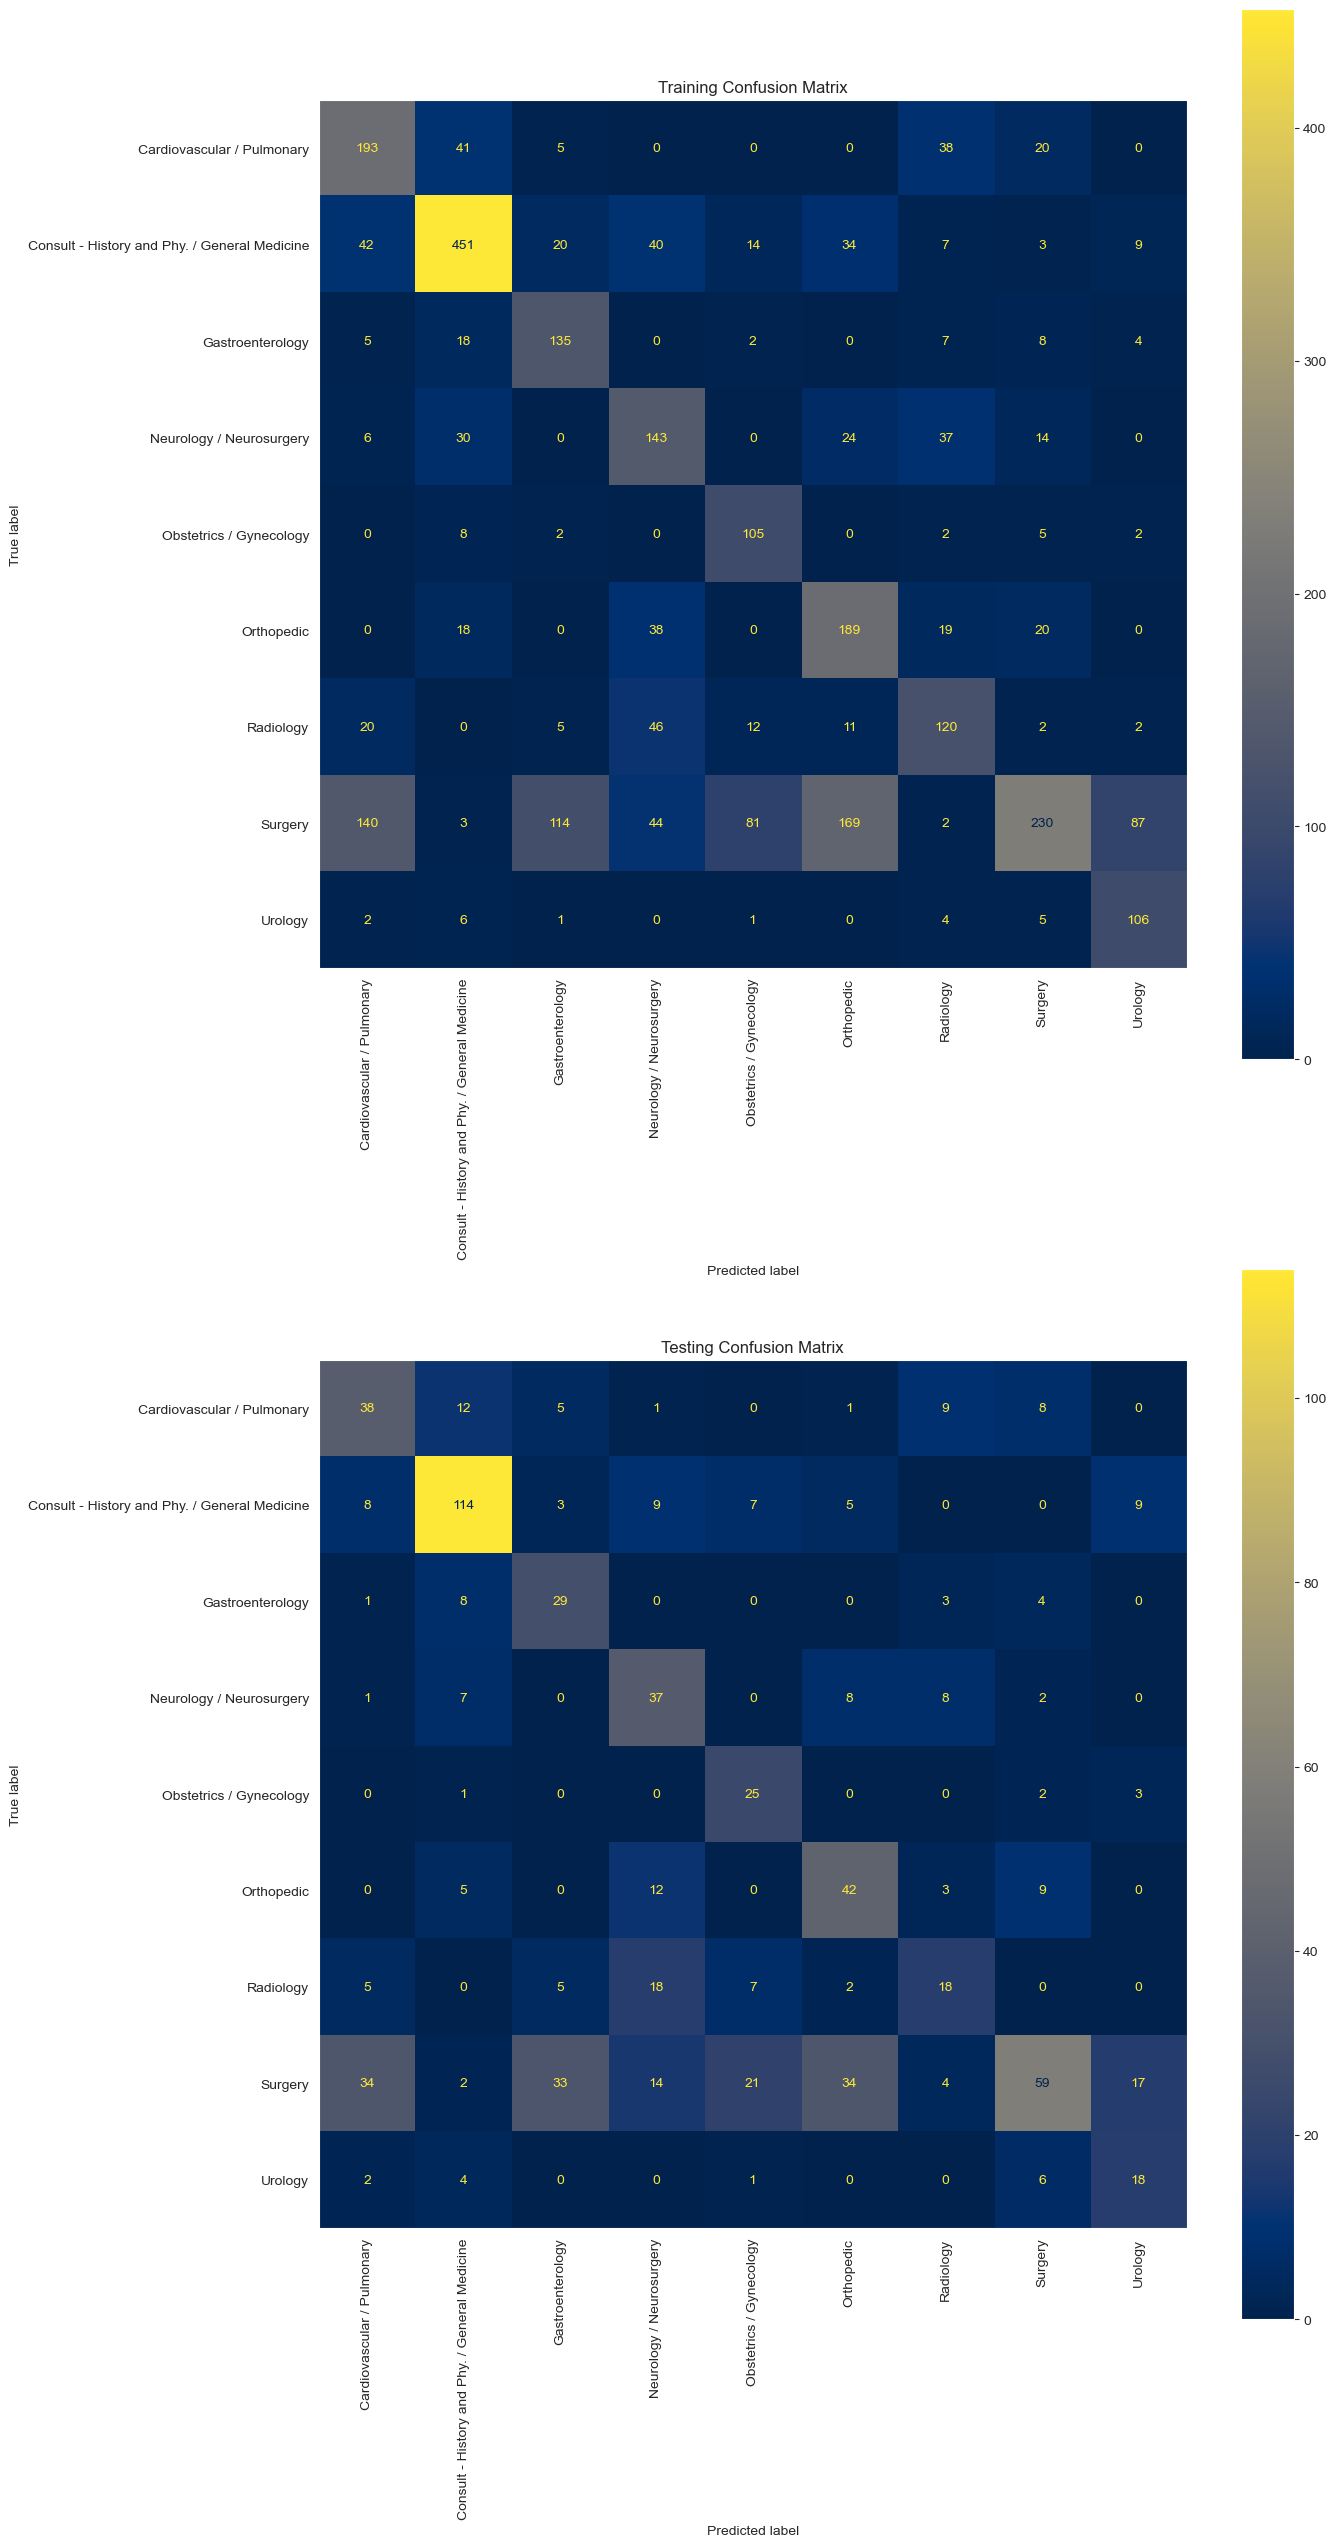

In [98]:
best_cat = evaluate_grid(cat_grid)